In [192]:
# Importamos las librerias necesarias para trabajar mas adelante 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, log_loss
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import joblib
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input
#from tensorflow.keras.utils import to_categorical
# import tensorflow_addons as tfa


In [3]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')

In [4]:
### Vista de datos
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [5]:
### Columnas, ¿cuáles son las variables de nuestra base?
df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [6]:
#eliminamos la columna unnamed:0 pq es como un índice
df = df.drop('Unnamed: 0', axis = 1)

In [7]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,143928.000000,144159.000000,142152.000000,82658.000000,75616.000000,135159.000000,143645.000000,142351.000000,142759.000000,140907.000000,130351.000000,130388.000000,89542.000000,86076.000000,143646.000000,141805.000000,142153.000000
mean,12.195873,23.223176,2.361516,5.468616,7.611241,40.036564,14.044742,18.663164,68.877290,51.537432,1017.649277,1015.255184,4.447287,4.509770,16.992780,21.685249,2.361242
std,6.398018,7.118770,8.479338,4.193871,3.785612,13.607212,8.915610,8.810276,19.029576,20.796720,7.107132,7.037981,2.887161,2.720306,6.488045,6.936358,8.479084
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


In [8]:
# Vemos todas las localidades que tiene nuestra base de datos
df['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [9]:
# Las localidades que queremos evaluar son Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport. El resto las eliminamos según el enunciado del tp
categorias_importantes = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
df_filtrado = df[df['Location'].isin(categorias_importantes)]

![Australia](Australia.JPG)

Como vemos que las localidades están muy alejadas (Las mas lejanas están al rededor de 700km de distancia) y esto puede influenciar en algunas de las variables de nuestro data set (como la evaporación, la cantidad de lluvia por día, etc) elegimos descartar la variable location para poder concentrarnos en el resto de las variables.
(ya que el enunciado lo daba como posibilidad)

In [10]:
#eliminamos la columna location
df_filtrado = df_filtrado.drop('Location', axis = 1)

In [11]:
#miramos cuantos datos nos quedan en el data set, las variables y su tipo y cuantos datos nulos tienen
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25041 entries, 6047 to 102519
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              25041 non-null  object 
 1   MinTemp           24473 non-null  float64
 2   MaxTemp           24485 non-null  float64
 3   Rainfall          24157 non-null  float64
 4   Evaporation       22176 non-null  float64
 5   Sunshine          19751 non-null  float64
 6   WindGustDir       23421 non-null  object 
 7   WindGustSpeed     23424 non-null  float64
 8   WindDir9am        23667 non-null  object 
 9   WindDir3pm        24620 non-null  object 
 10  WindSpeed9am      24688 non-null  float64
 11  WindSpeed3pm      24706 non-null  float64
 12  Humidity9am       24106 non-null  float64
 13  Humidity3pm       24156 non-null  float64
 14  Pressure9am       24210 non-null  float64
 15  Pressure3pm       24219 non-null  float64
 16  Cloud9am          18866 non-null  float64

In [12]:
### Cantidad de valores faltantes.

df_filtrado.isna().sum()

Date                   0
MinTemp              568
MaxTemp              556
Rainfall             884
Evaporation         2865
Sunshine            5290
WindGustDir         1620
WindGustSpeed       1617
WindDir9am          1374
WindDir3pm           421
WindSpeed9am         353
WindSpeed3pm         335
Humidity9am          935
Humidity3pm          885
Pressure9am          831
Pressure3pm          822
Cloud9am            6175
Cloud3pm            6358
Temp9am              580
Temp3pm              572
RainToday            884
RainTomorrow         883
RainfallTomorrow     883
dtype: int64

Como eliminamos la variable location ahora nos quedan 8 registros por día, por ende vamos a intentar llenar los nulos de las variables con una medida resumen por día

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


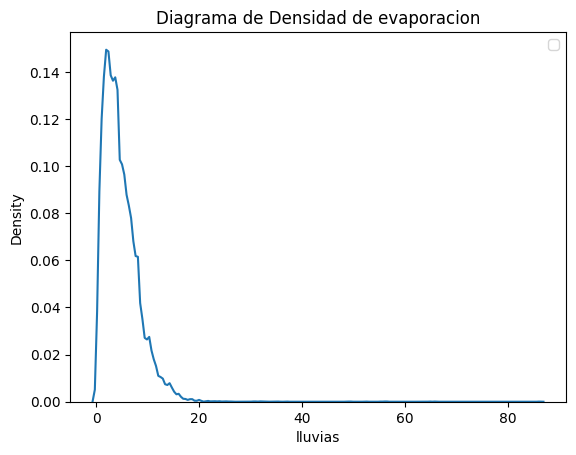

In [13]:
# Vemos como se ditribuye la evaporacion
# Graficamos el diagrama de densidades
bandwidth = 0.5
sns.kdeplot(data=df_filtrado['Evaporation'], bw_adjust=bandwidth)
plt.title('Diagrama de Densidad de evaporacion')
plt.xlabel('lluvias')
plt.legend()

como vemos muchos outliers vamos a usar la mediana por dia en vez de la media

In [14]:
# Imputamos los valores faltantes de Evaporation con la mediana calculada por dia
mediana_Evaporation = df_filtrado.groupby('Date')['Evaporation'].median()
df_filtrado['Evaporation'] = df_filtrado.apply(lambda x: mediana_Evaporation[x['Date']] if pd.isnull(x['Evaporation']) else x['Evaporation'], axis=1)

In [15]:
# Verificamos que Evaporation no tenga valores nulos
df_filtrado['Evaporation'].isnull().sum()

0

Vamos a crear una variable que sea epocas del año porque la lluvia en invierno es diferente a la del verano por ejemplo.
Armamos una función para determinar las estaciones del año (usamos las estaciones de australia) 
* Otoño: del 1 de marzo al 31 de mayo. 
* Invierno: del 1 de junio al 31 de agosto. 
* Primavera: del 1 de septiembre al 30 de noviembre. 
* Verano: del 1 de diciembre al 28 de febrero.

In [16]:
# Primero tengo que convertir a la variable date en tipo datetime
df_filtrado = df_filtrado.copy()  # Crear una copia del DataFrame
df_filtrado['Date'] = pd.to_datetime(df_filtrado['Date'])
df_filtrado['Date'].head()

6047   2009-01-01
6048   2009-01-02
6049   2009-01-03
6050   2009-01-04
6051   2009-01-05
Name: Date, dtype: datetime64[ns]

In [17]:
# Armamos la funcion para determinar la estacion
def determinar_estacion(fecha):
    # extraemos el mes
    mes = fecha.month
    # Determinamos las estaciones
    if  3<= mes <=5:
        return "Otoño"
    elif 6<= mes <= 8:
        return "Invierno"
    elif 9 <= mes <= 11:
        return "Primavera"
    else:
        return "Verano"

# Aplicamos la función determinar_estacion al DataFrame df_filtrado
df_filtrado['Estacion'] = df_filtrado['Date'].apply(lambda x: determinar_estacion(x))

# Mostramos el DataFrame con la nueva columna de estaciones
df_filtrado.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow,Estacion
6047,2009-01-01,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0,Verano
6048,2009-01-02,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0,Verano
6049,2009-01-03,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,...,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0,Verano
6050,2009-01-04,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0,Verano
6051,2009-01-05,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0,Verano


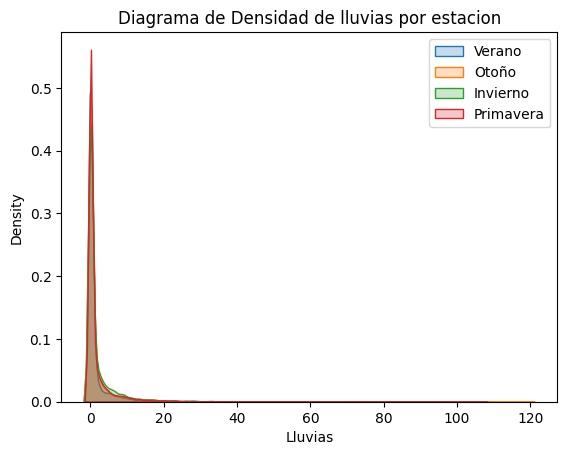

In [18]:
# Creamos un df por estación para luego poder comparar la variable Rainfall 
verano_data = df_filtrado[df_filtrado['Estacion'] == 'Verano']
otoño_data = df_filtrado[df_filtrado['Estacion'] == 'Otoño']
invierno_data = df_filtrado[df_filtrado['Estacion'] == 'Invierno']
primavera_data = df_filtrado[df_filtrado['Estacion'] == 'Primavera']

# Graficamos un diagrama de densidades
bandwidth = 0.5
sns.kdeplot(data=verano_data['Rainfall'], fill=True, label='Verano', bw_adjust=bandwidth)
sns.kdeplot(data=otoño_data['Rainfall'], fill=True, label='Otoño', bw_adjust=bandwidth)
sns.kdeplot(data=invierno_data['Rainfall'], fill=True, label='Invierno', bw_adjust=bandwidth)
sns.kdeplot(data=primavera_data['Rainfall'], fill=True, label='Primavera', bw_adjust=bandwidth)
plt.title('Diagrama de Densidad de lluvias por estacion')
plt.xlabel('Lluvias')
plt.legend()

Como vemos que todas la estaciones se distribuyen similares, no vamos a sacar la lluvia por estacion 

Text(0.5, 1.0, 'Rainfall')

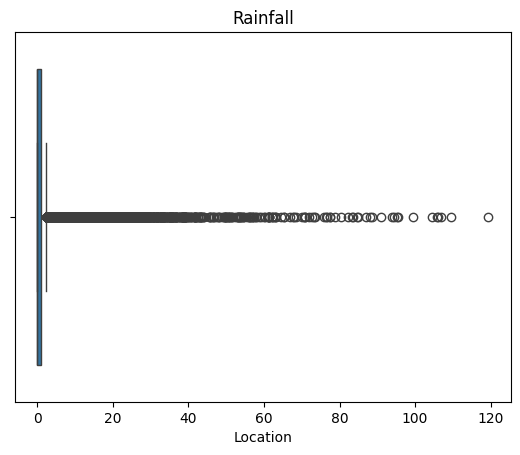

In [19]:
# Vemos como se ditribuye la lluvia
sns.boxplot(x='Rainfall', data=df_filtrado)
plt.xlabel('Location')
plt.title('Rainfall')

In [20]:
# Como vemos que la distribución de la lluvia no se diferencia por estación decidimos rellenar 'Rainfall' por día. 
# Usamos la mediana por la cantidad de valores outliers que tiene
mediana_Rainfall = df_filtrado.groupby('Date')['Rainfall'].median()

for index, row in df_filtrado.iterrows():
    if pd.isnull(row['Rainfall']):
        # Si el valor de 'Rainfall' es nulo, rellenar con la mediana correspondiente al día
        df_filtrado.at[index, 'Rainfall'] = mediana_Rainfall.loc[row['Date']]
        

In [21]:
# Verificamos que no hayan quedado valores sin asignar 
df_filtrado['Rainfall'].isnull().sum()

0

In [22]:
# Imputamos los valores faltantes de Sunshine con la mediana calculada por dia 
mediana_Sunshine = df_filtrado.groupby('Date')['Sunshine'].median()

df_filtrado['Sunshine'] = df_filtrado.apply(lambda x: mediana_Sunshine[x['Date']] if pd.isnull(x['Sunshine']) else x['Sunshine'], axis=1)

In [23]:
# Verificamos que no hayan quedado valores de Sunshine sin imputar
df_filtrado['Sunshine'].isnull().sum()

0

In [24]:
# Imputamos los valores faltantes de WindGustSpeed con la mediana clculada por dia 
mediana_WindGustSpeed = df_filtrado.groupby('Date')['WindGustSpeed'].median()

df_filtrado['WindGustSpeed'] = df_filtrado.apply(lambda x: mediana_WindGustSpeed[x['Date']] if pd.isnull(x['WindGustSpeed']) else x['WindGustSpeed'], axis=1)

In [25]:
# Verificamos que no hayan quedado valores de WindGustSpeed sin imputar
df_filtrado[df_filtrado['WindGustSpeed'].isna()]

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow,Estacion
30286,2008-05-30,10.9,21.0,0.2,1.4,5.6,NaN,NaN,W,E,...,1032.0,1028.7,1.0,2.0,12.7,19.6,No,No,0.0,Otoño
45784,2008-05-30,-0.1,18.0,0.0,2.0,8.6,NaN,NaN,N,NNW,...,1033.2,1028.7,1.0,1.0,5.6,17.4,No,No,0.0,Otoño


In [26]:
df_filtrado[df_filtrado['Date'] == '2008-05-30'][['Date', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']]
# Para esta fecha (2008-05-30), hay solo dos ciudades donde se tomaron datos, y ninguno de los dos tiene valores en WindGustSpeed,
# asi que vamos a imputar por el mayor entre WindSpeed9am y WindSpeed3pm

if df_filtrado['WindGustSpeed'].isnull().any():
    df_filtrado['WindGustSpeed'] = np.maximum(df_filtrado['WindSpeed3pm'], df_filtrado['WindSpeed9am'])


In [27]:
# Vemos que se hayan asignado correctamente los valores 
df_filtrado[df_filtrado['Date'] == '2008-05-30'][['Date', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']]

,Date,WindGustSpeed,WindSpeed9am,WindSpeed3pm
30286,2008-05-30,19.0,19.0,7.0
45784,2008-05-30,15.0,2.0,15.0


In [28]:
# Imputamos los valores de WindSpeed9am y WindSpeed3pm por fecha utilizando la mediana
mediana_WindSpeed9am = df_filtrado.groupby('Date')['WindSpeed9am'].median()
df_filtrado['WindSpeed9am'] = df_filtrado.apply(lambda x: mediana_WindSpeed9am[x['Date']] if pd.isnull(x['WindSpeed9am']) else x['WindSpeed9am'], axis=1)

mediana_WindSpeed3pm = df_filtrado.groupby('Date')['WindSpeed3pm'].median()
df_filtrado['WindSpeed3pm'] = df_filtrado.apply(lambda x: mediana_WindSpeed3pm[x['Date']] if pd.isnull(x['WindSpeed3pm']) else x['WindSpeed3pm'], axis=1)

In [29]:
# Verificamos que no hayan quedado nulos
df_filtrado['WindSpeed9am'].isnull().sum()
df_filtrado['WindSpeed3pm'].isnull().sum()

0

In [30]:
# Para los valores de WindGustDir, WindDir9am, y WindDir3pm, verificamos cuantos tienen los tres valores iguales 
df_filtrado['Todos_Iguales'] = (df_filtrado['WindGustDir'].notna()) & (df_filtrado['WindDir9am'].notna()) & (df_filtrado['WindDir3pm'].notna()) & (df_filtrado['WindGustDir'] == df_filtrado['WindDir9am']) & (df_filtrado['WindGustDir'] == df_filtrado['WindDir3pm'])

df_filtrado['Todos_Iguales'].sum()

2173

In [31]:
# Vamos a eliminar la columna Todos iguales porque hay pocos valores todos iguales por lo que no la voy a utilizar 
df_filtrado.drop('Todos_Iguales', axis=1, inplace=True)

In [32]:
# Verificamos si hay datos de Wind que tengan valores faltantes en las tres columnas (no podriamos completar por este método)
df_filtrado[['WindDir9am', 'WindDir3pm', 'WindGustDir']].isna().all(axis=1).sum()

313

In [33]:
# Como hay 313 valores que no tienen datos ninguna de las tres columnas. Vamos a completar los valores por día 
# Utilizamos la moda porque es un valor categórico
# Calculamos la moda por fecha, para cada variable, y si todas las localidades tienen NaN, completa con None 
moda_Wind = df_filtrado.groupby('Date')[['WindDir9am', 'WindDir3pm', 'WindGustDir']].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Unimos las modas obtenidas con el DataFrame original para luego poder imputar
df_filtrado = pd.merge(df_filtrado, moda_Wind, on='Date', suffixes=('', '_moda'))

# Completamos los valores faltantes utilizando la moda correspondiente
df_filtrado['WindGustDir'].fillna(df_filtrado['WindGustDir_moda'], inplace=True)
df_filtrado['WindDir9am'].fillna(df_filtrado['WindDir9am_moda'], inplace=True)
df_filtrado['WindDir3pm'].fillna(df_filtrado['WindDir3pm_moda'], inplace=True)

# Eliminamos las columnas de moda porque ya no nos van a servir más
df_filtrado.drop(columns=['WindGustDir_moda', 'WindDir9am_moda', 'WindDir3pm_moda'], inplace=True)


C:\Users\u631832\AppData\Local\Temp\ipykernel_2124\396454794.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtrado['WindGustDir'].fillna(df_filtrado['WindGustDir_moda'], inplace=True)
C:\Users\u631832\AppData\Local\Temp\ipykernel_2124\396454794.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [34]:
# Verificamos que todos los valores sean distintos de None
df_filtrado[['WindDir9am', 'WindDir3pm', 'WindGustDir']].isna().any()

WindDir9am      True
WindDir3pm     False
WindGustDir     True
dtype: bool

In [35]:
df_filtrado[df_filtrado['WindDir9am'].isna()]

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow,Estacion
3034,2008-02-27,19.0,29.0,22.2,8.2,3.3,W,15.0,NaN,NNE,...,1014.1,1010.6,7.0,7.0,21.3,24.7,Yes,Yes,4.2,Verano
9477,2008-02-27,11.7,27.6,0.0,7.8,8.1,W,NaN,NaN,W,...,1013.6,1009.1,2.0,6.0,17.6,26.8,No,No,0.0,Verano


In [36]:
# Observamos que la fecha dónde no tenemos ningún valor de WindDir9am, los valores de WindGustDir coinciden, 
#asi que decidimos imputar los valores con el valor de WindGustDir.

df_filtrado.loc[df_filtrado['WindDir9am'].isna(), 'WindDir9am'] = df_filtrado.loc[df_filtrado['WindDir9am'].isna(), 'WindGustDir']

In [37]:
# Volvemos a verificar
df_filtrado['WindDir9am'].isnull().sum()

0

In [38]:
# Miramos que valores tienen WindDir9 am y WindDir3pm en los valores faltantes de WindGustDir
df_filtrado[df_filtrado['WindGustDir'].isna()][['Date', 'Estacion', 'WindDir9am', 'WindDir3pm']]

,Date,Estacion,WindDir9am,WindDir3pm
3109,2008-05-12,Otoño,W,E
3127,2008-05-30,Otoño,W,E
9552,2008-05-12,Otoño,E,NNW
9570,2008-05-30,Otoño,N,NNW


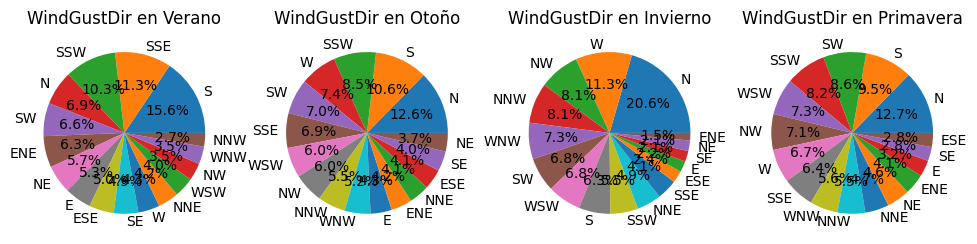

In [39]:
# Hacemos un grafico de torta por estacion para ver si hay alguna tendencia en cada estacion
df_verano = df_filtrado[df_filtrado['Estacion'] == 'Verano']
df_otoño = df_filtrado[df_filtrado['Estacion'] == 'Otoño']
df_invierno = df_filtrado[df_filtrado['Estacion'] == 'Invierno']
df_primavera = df_filtrado[df_filtrado['Estacion'] == 'Primavera']

counts_verano = df_verano['WindGustDir'].value_counts()
counts_otoño = df_otoño['WindGustDir'].value_counts()
counts_invierno = df_invierno['WindGustDir'].value_counts()
counts_primavera = df_primavera['WindGustDir'].value_counts()

plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.pie(counts_verano, labels=counts_verano.index, autopct='%1.1f%%')
plt.title('WindGustDir en Verano')

plt.subplot(1, 4, 2)
plt.pie(counts_otoño, labels=counts_otoño.index, autopct='%1.1f%%')
plt.title('WindGustDir en Otoño')

plt.subplot(1, 4, 3)
plt.pie(counts_invierno, labels=counts_invierno.index, autopct='%1.1f%%')
plt.title('WindGustDir en Invierno')

plt.subplot(1, 4, 4)
plt.pie(counts_primavera, labels=counts_primavera.index, autopct='%1.1f%%')
plt.title('WindGustDir en Primavera')

plt.show()


In [40]:
# Completamos los valores faltantes de WindGustDir con el valor que más aparece en esa estacion
# En este caso los valores faltantes corresponden a otoño, por lo que completamos con N 
df_filtrado['WindGustDir'].fillna('N', inplace=True)

C:\Users\u631832\AppData\Local\Temp\ipykernel_2124\415064723.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtrado['WindGustDir'].fillna('N', inplace=True)


In [41]:
# Imputamos los valores de WindGustSpeed  por fecha utilizando la mediana
mediana_WindGustSpeed = df_filtrado.groupby('Date')['WindGustSpeed'].median()
df_filtrado['WindGustSpeed'] = df_filtrado.apply(lambda x: mediana_WindGustSpeed[x['Date']] if pd.isnull(x['WindGustSpeed']) else x['WindGustSpeed'], axis=1)


In [42]:
df_filtrado['WindGustSpeed'].isnull().sum()

0

In [43]:
# Imputamos los valores de Humidity9am y Humidity3pm por fecha utilizando la mediana
mediana_Humidity9am = df_filtrado.groupby('Date')['Humidity9am'].median()
df_filtrado['Humidity9am'] = df_filtrado.apply(lambda x: mediana_Humidity9am[x['Date']] if pd.isnull(x['Humidity9am']) else x['Humidity9am'], axis=1)

mediana_Humidity3pm = df_filtrado.groupby('Date')['Humidity3pm'].median()
df_filtrado['Humidity3pm'] = df_filtrado.apply(lambda x: mediana_Humidity3pm[x['Date']] if pd.isnull(x['Humidity3pm']) else x['Humidity3pm'], axis=1)

In [44]:
# Verificamos que no hayan quedado nulos
df_filtrado['Humidity3pm'].isnull().sum()
df_filtrado['Humidity9am'].isnull().sum()

0

In [45]:
# Imputamos los valores de Pressure9am y Pressure3pm por fecha utilizando la mediana
mediana_Pressure9am = df_filtrado.groupby('Date')['Pressure9am'].median()
df_filtrado['Pressure9am'] = df_filtrado.apply(lambda x: mediana_Pressure9am[x['Date']] if pd.isnull(x['Pressure9am']) else x['Pressure9am'], axis=1)

mediana_Pressure3pm = df_filtrado.groupby('Date')['Pressure3pm'].median()
df_filtrado['Pressure3pm'] = df_filtrado.apply(lambda x: mediana_Pressure3pm[x['Date']] if pd.isnull(x['Pressure3pm']) else x['Pressure3pm'], axis=1)

In [46]:
# Verificamos que no hayan quedado nulos
df_filtrado['Pressure9am'].isnull().sum()
df_filtrado['Pressure3pm'].isnull().sum()

0

In [47]:
# Imputamos los valores de Temp9am y Temp3pm por fecha utilizando la mediana
mediana_Temp9am = df_filtrado.groupby('Date')['Temp9am'].median()
df_filtrado['Temp9am'] = df_filtrado.apply(lambda x: mediana_Temp9am[x['Date']] if pd.isnull(x['Temp9am']) else x['Temp9am'], axis=1)

mediana_Temp3pm = df_filtrado.groupby('Date')['Temp3pm'].median()
df_filtrado['Temp3pm'] = df_filtrado.apply(lambda x: mediana_Temp3pm[x['Date']] if pd.isnull(x['Temp3pm']) else x['Temp3pm'], axis=1)

In [48]:
# Verificamos que no hayan quedado nulos
df_filtrado['Temp9am'].isnull().sum()
df_filtrado['Temp3pm'].isnull().sum()

0

In [49]:
# Imputamos los valores de Cloud9am y Cloud3pm por fecha utilizando la mediana
mediana_Cloud9am = df_filtrado.groupby('Date')['Cloud9am'].median()
df_filtrado['Cloud9am'] = df_filtrado.apply(lambda x: mediana_Cloud9am[x['Date']] if pd.isnull(x['Cloud9am']) else x['Cloud9am'], axis=1)

mediana_Cloud3pm = df_filtrado.groupby('Date')['Cloud3pm'].median()
df_filtrado['Cloud3pm'] = df_filtrado.apply(lambda x: mediana_Cloud3pm[x['Date']] if pd.isnull(x['Cloud3pm']) else x['Cloud3pm'], axis=1)

In [50]:
# Verificamos que no hayan quedado nulos
df_filtrado['Cloud9am'].isnull().sum()
df_filtrado['Cloud3pm'].isnull().sum()

0

In [51]:
# Imputamos los valores de RainToday por fecha utilizando la moda (porque es un valor tipo object)
# Primero vamos a pasar los valores 
moda_RainToday = df_filtrado.groupby('Date')['RainToday'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_filtrado['RainToday'] = df_filtrado['RainToday'].fillna(moda_RainToday)

In [52]:
# Verificamos que todos los valores tengan datos 
df_filtrado['RainToday'].isnull().sum()

0

In [53]:
# Imputamos los valores de RainTomorrow utilizando la moda porque es una variable categórica
moda_RainTomorrow = df_filtrado.groupby('Date')['RainTomorrow'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_filtrado['RainTomorrow'] = df_filtrado['RainTomorrow'].fillna(moda_RainTomorrow)

In [54]:
# Verificamos 
df_filtrado['RainTomorrow'].isnull().sum()

0

In [55]:
# Completamos los valores faltantes de RainfallTomorrow agrupando por dia 
mediana_RainfallTomorrow = df_filtrado.groupby('Date')['RainfallTomorrow'].median()
df_filtrado['RainfallTomorrow'] = df_filtrado.apply(lambda x: mediana_RainfallTomorrow[x['Date']] if pd.isnull(x['RainfallTomorrow']) else x['RainfallTomorrow'], axis=1)

In [56]:
# Verificamos que no hayan quedado nulos
df_filtrado['RainfallTomorrow'].isnull().sum()

0

([0, 1, 2, 3],
 [Text(0, 0, 'Verano'),
  Text(1, 0, 'Otoño'),
  Text(2, 0, 'Invierno'),
  Text(3, 0, 'Primavera')])

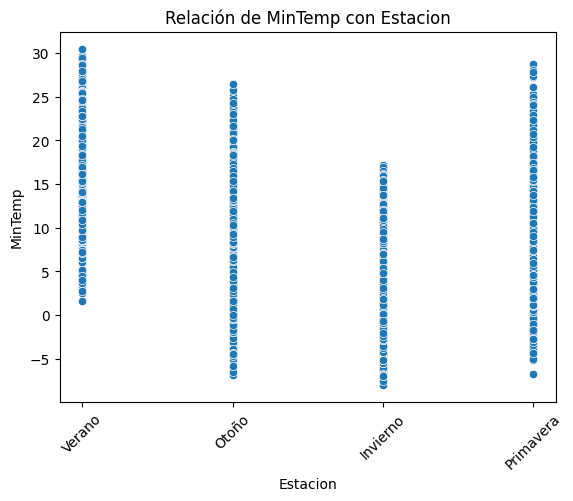

In [57]:
# Vemos como se ditribuye la temperatura mínima según las estaciones para ver si podemos sacar la media según estacion
sns.scatterplot(x='Estacion', y='MinTemp', data=df_filtrado)
plt.xlabel('Estacion')
plt.ylabel('MinTemp')
plt.title('Relación de MinTemp con Estacion')
plt.xticks(rotation= 45)

([0, 1, 2, 3],
 [Text(0, 0, 'Verano'),
  Text(1, 0, 'Otoño'),
  Text(2, 0, 'Invierno'),
  Text(3, 0, 'Primavera')])

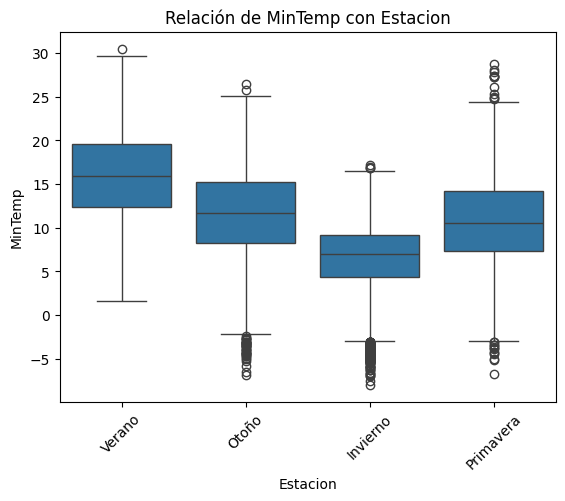

In [58]:
# Vemos como se ditribuye la temperatura mínima según las estaciones para ver si podemos sacar la media según estacion
sns.boxplot(x='Estacion', y='MinTemp', data=df_filtrado)
plt.xlabel('Estacion')
plt.ylabel('MinTemp')
plt.title('Relación de MinTemp con Estacion')
plt.xticks(rotation= 45)

([0, 1, 2, 3],
 [Text(0, 0, 'Verano'),
  Text(1, 0, 'Otoño'),
  Text(2, 0, 'Invierno'),
  Text(3, 0, 'Primavera')])

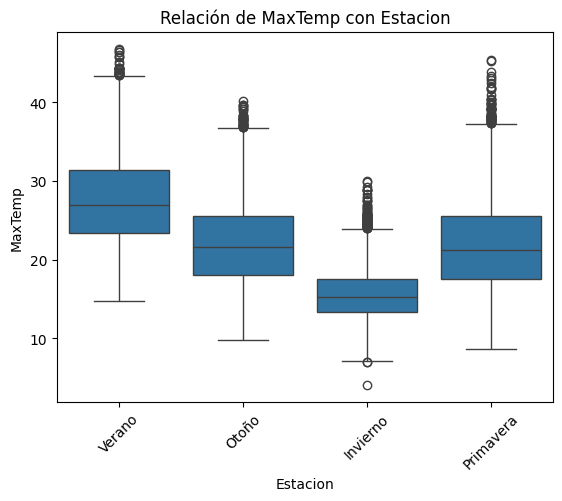

In [59]:
# Vemos como se ditribuye la temperatura maxima según las estaciones para ver si podemos sacar la media según estacion
sns.boxplot(x='Estacion', y='MaxTemp', data=df_filtrado)
plt.xlabel('Estacion')
plt.ylabel('MaxTemp')
plt.title('Relación de MaxTemp con Estacion')
plt.xticks(rotation= 45)

In [60]:
# Comprobamos si quedo algun valor nulo
df_filtrado.isnull().sum()

Date                  0
MinTemp             568
MaxTemp             556
Rainfall              0
Evaporation           0
Sunshine              0
WindGustDir           0
WindGustSpeed         0
WindDir9am            0
WindDir3pm            0
WindSpeed9am          0
WindSpeed3pm          0
Humidity9am           0
Humidity3pm           0
Pressure9am           0
Pressure3pm           0
Cloud9am              0
Cloud3pm              0
Temp9am               0
Temp3pm               0
RainToday             0
RainTomorrow          0
RainfallTomorrow      0
Estacion              0
dtype: int64

In [61]:
# Antes de completar los datos faltantes, dividimos nuestros datos en train y test
#como tenemos datos desde el 2009 hasta mediados de 2017 vamos a tomar como test el 20% de nuestros datos que sería aproximadamente 20 meses y para hacerlo un poco mas fácil nos quedamos con todo 2016 y todo 2017 como test  (18 meses) y usamos el resto como train (es un 18% aprox de mi base de datos)
df_train = df_filtrado.loc[df_filtrado['Date'] < '2016-01-01']
df_test = df_filtrado.loc[df_filtrado['Date'] >= '2016-01-01']

In [62]:
# Los datos faltantes de las variables MinTemp y MaxTemp las rellenamos con la mediana de cada estación, 
#ya que en los respectivos boxplots podemos observar que hay outliers

# Lo hago para mis datos de entrenamiento 
mediana_MaxTemp_train = df_train.groupby('Estacion')['MaxTemp'].median()
for estacion in mediana_MaxTemp_train.index:
    df_train.loc[df_train['Estacion'] == estacion, 'MaxTemp'] = df_train.loc[df_train['Estacion'] == estacion, 'MaxTemp'].fillna(mediana_MaxTemp_train[estacion])

mediana_MinTemp_train = df_train.groupby('Estacion')['MinTemp'].median()
for estacion in mediana_MinTemp_train.index:
    df_train.loc[df_train['Estacion'] == estacion, 'MinTemp'] = df_train.loc[df_train['Estacion'] == estacion, 'MinTemp'].fillna(mediana_MinTemp_train[estacion])

# Y por separado para msi datos de test
for estacion in mediana_MaxTemp_train.index:
    df_test.loc[df_test['Estacion'] == estacion, 'MaxTemp'] = df_test.loc[df_test['Estacion'] == estacion, 'MaxTemp'].fillna(mediana_MaxTemp_train[estacion])

for estacion in mediana_MinTemp_train.index:
    df_test.loc[df_test['Estacion'] == estacion, 'MinTemp'] = df_test.loc[df_test['Estacion'] == estacion, 'MinTemp'].fillna(mediana_MinTemp_train[estacion])


In [63]:
print(df_train['MaxTemp'].isnull().sum())
print(df_train['MinTemp'].isnull().sum())
print(df_test['MaxTemp'].isnull().sum())
print(df_test['MinTemp'].isnull().sum())

0
0
0
0


Ahora vamos a generar dummies en las variables categóricas

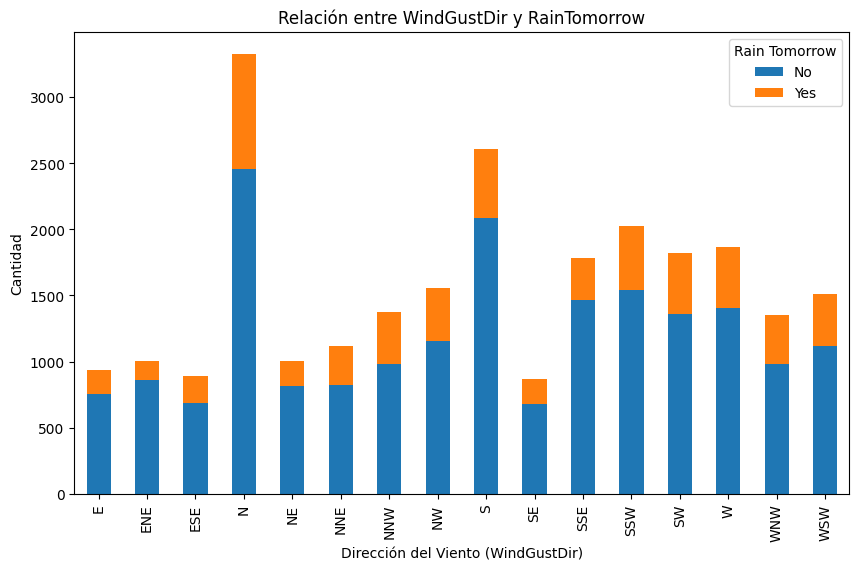

In [64]:
# Agrupamos por WindGustDir y contar los valores de RainTomorrow
grouped = df_filtrado.groupby('WindGustDir')['RainTomorrow'].value_counts().unstack()

# Hacemos el gráfico de barras para ver la proprcion de si y no en Rain Tomorrow
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Dirección del Viento (WindGustDir)')
plt.ylabel('Cantidad')
plt.title('Relación entre WindGustDir y RainTomorrow')
plt.legend(title='Rain Tomorrow')
plt.show()


Como vemos que la proporcion de si llueve o no mañana es similar para todas las direcciones de viento vamos a agruparlas en 4 direcciones: E, S, W, N

In [65]:
# Hacemos una función para agrupar las direcciones de viento 
def determinar_viento(viento):
    # Determinamos las estaciones
    if viento in ["NE", "ENE", "ESE"]:
        return "E"
    elif viento in ["SSE", "SE", "SSW"]:
        return "S"
    elif viento in ["NNE", "NNW", "NW"]:
        return "N"
    else:
        return "W"

# Aplicamos la función determinar_viento a ambos DataFrame (df_train y df_test)
df_train['WindGustDir_agr'] = df_train['WindGustDir'].apply(lambda x: determinar_viento(x))
df_test['WindGustDir_agr'] = df_test['WindGustDir'].apply(lambda x: determinar_viento(x))

df_train['WindDir9am_agr'] = df_train['WindDir9am'].apply(lambda x: determinar_viento(x))
df_test['WindDir9am_agr'] = df_test['WindDir9am'].apply(lambda x: determinar_viento(x))

df_train['WindDir3pm_agr'] = df_train['WindDir3pm'].apply(lambda x: determinar_viento(x))
df_test['WindDir3pm_agr'] = df_test['WindDir3pm'].apply(lambda x: determinar_viento(x))

# Mostramos el DataFrame con la nueva columna de estaciones
df_test.head()


C:\Users\u631832\AppData\Local\Temp\ipykernel_2124\914327287.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['WindGustDir_agr'] = df_train['WindGustDir'].apply(lambda x: determinar_viento(x))
C:\Users\u631832\AppData\Local\Temp\ipykernel_2124\914327287.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['WindGustDir_agr'] = df_test['WindGustDir'].apply(lambda x: determinar_viento(x))
C:\Users\u631832\AppData\Local\Temp\ipykernel_2124\914327287.py:17: SettingWithCopyWarning: 
A value i

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow,Estacion,WindGustDir_agr,WindDir9am_agr,WindDir3pm_agr
2467,2016-01-01,24.5,36.4,0.0,12.8,3.6,S,20.0,ENE,SSE,...,1.0,28.3,34.5,No,No,0.0,Verano,W,E,S
2468,2016-01-02,26.5,33.0,0.0,23.0,3.3,WNW,19.0,SW,SW,...,7.0,27.6,31.3,No,No,0.0,Verano,W,W,W
2469,2016-01-03,22.3,29.8,0.0,6.0,7.8,E,28.0,NNE,ENE,...,7.0,24.0,26.3,No,No,0.0,Verano,W,N,E
2470,2016-01-04,16.3,28.2,0.0,9.6,1.5,ENE,19.0,E,SSE,...,7.0,22.1,25.8,No,No,0.0,Verano,E,W,S
2471,2016-01-05,19.0,30.7,0.0,5.0,6.6,SSE,20.0,ESE,SSE,...,4.0,23.9,29.5,No,No,0.0,Verano,S,E,S


Hacemos la dummy en base a la agrupacion que hicimos recién y eliminamos las columnas originales porque ya no las vamos a utilizar mas

In [66]:
# Para la variable WindGustDir
dummies_WindGustDir_train = pd.get_dummies(df_train['WindGustDir_agr'], dtype=int, drop_first=True)
dummies_WindGustDir_test = pd.get_dummies(df_test['WindGustDir_agr'], dtype=int, drop_first=True)

dummies_WindGustDir_train = dummies_WindGustDir_train.rename(columns={'N': 'WindGustDir_N', 'S': 'WindGustDir_S', 'W': 'WindGustDir_W'})
dummies_WindGustDir_test = dummies_WindGustDir_test.rename(columns={'N': 'WindGustDir_N', 'S': 'WindGustDir_S', 'W': 'WindGustDir_W'})

df_train = df_train.drop('WindGustDir', axis=1)
df_test = df_test.drop('WindGustDir', axis=1)
df_train = df_train.drop('WindGustDir_agr', axis=1)
df_test = df_test.drop('WindGustDir_agr', axis=1)

df_train = pd.concat([df_train, dummies_WindGustDir_train], axis=1)
df_test = pd.concat([df_test, dummies_WindGustDir_test], axis=1)

In [67]:
# Para la variable WindDir9am
dummies_WindDir9am_train = pd.get_dummies(df_train['WindDir9am_agr'], dtype=int, drop_first=True)
dummies_WindDir9am_test = pd.get_dummies(df_test['WindDir9am_agr'], dtype=int, drop_first=True)

dummies_WindDir9am_train = dummies_WindDir9am_train.rename(columns={'N': 'WindDir9am_N', 'S': 'WindDir9am_S', 'W': 'WindDir9am_W'})
dummies_WindDir9am_test = dummies_WindDir9am_test.rename(columns={'N': 'WindDir9am_N', 'S': 'WindDir9am_S', 'W': 'WindDir9am_W'})

df_train = df_train.drop('WindDir9am', axis=1)
df_test = df_test.drop('WindDir9am', axis=1)
df_train = df_train.drop('WindDir9am_agr', axis=1)
df_test = df_test.drop('WindDir9am_agr', axis=1)

df_train = pd.concat([df_train, dummies_WindDir9am_train], axis=1)
df_test = pd.concat([df_test, dummies_WindDir9am_test], axis=1)

In [68]:
# Para la variable WindDir3pm
dummies_WindDir3pm_train = pd.get_dummies(df_train['WindDir3pm_agr'], dtype=int, drop_first=True)
dummies_WindDir3pm_test = pd.get_dummies(df_test['WindDir3pm_agr'], dtype=int, drop_first=True)

dummies_WindDir3pm_train = dummies_WindDir3pm_train.rename(columns={'N': 'WindDir3pm_N', 'S': 'WindDir3pm_S', 'W': 'WindDir3pm_S'})
dummies_WindDir3pm_test = dummies_WindDir3pm_test.rename(columns={'N': 'WindDir3pm_N', 'S': 'WindDir3pm_S', 'W': 'WindDir3pm_S'})

df_train = df_train.drop('WindDir3pm', axis=1)
df_test = df_test.drop('WindDir3pm', axis=1)
df_train = df_train.drop('WindDir3pm_agr', axis=1)
df_test = df_test.drop('WindDir3pm_agr', axis=1)

df_train = pd.concat([df_train, dummies_WindDir3pm_train], axis=1)
df_test = pd.concat([df_test, dummies_WindDir3pm_test], axis=1)

In [69]:
# Para la variable RainToday
dummies_RainToday_train = pd.get_dummies(df_train['RainToday'], dtype=int, drop_first=True)
dummies_RainToday_test = pd.get_dummies(df_test['RainToday'], dtype=int, drop_first=True)

dummies_RainToday_train = dummies_RainToday_train.rename(columns={'Yes': 'RainToday'})
dummies_RainToday_test = dummies_RainToday_test.rename(columns={'Yes': 'RainToday'})

df_train = df_train.drop('RainToday', axis=1)
df_test = df_test.drop('RainToday', axis=1)

df_train = pd.concat([df_train, dummies_RainToday_train], axis=1)
df_test = pd.concat([df_test, dummies_RainToday_test], axis=1)

In [70]:
# Para la variable RainTomorrow
dummies_RainTomorrow_train = pd.get_dummies(df_train['RainTomorrow'], dtype=int, drop_first=True)
dummies_RainTomorrow_test = pd.get_dummies(df_test['RainTomorrow'], dtype=int, drop_first=True)

dummies_RainTomorrow_train = dummies_RainTomorrow_train.rename(columns={'Yes': 'RainTomorrow'})
dummies_RainTomorrow_test = dummies_RainTomorrow_test.rename(columns={'Yes': 'RainTomorrow'})

df_train = df_train.drop('RainTomorrow', axis=1)
df_test = df_test.drop('RainTomorrow', axis=1)

df_train = pd.concat([df_train, dummies_RainTomorrow_train], axis=1)
df_test = pd.concat([df_test, dummies_RainTomorrow_test], axis=1)

Text(0, 0.5, 'Frecuencia')

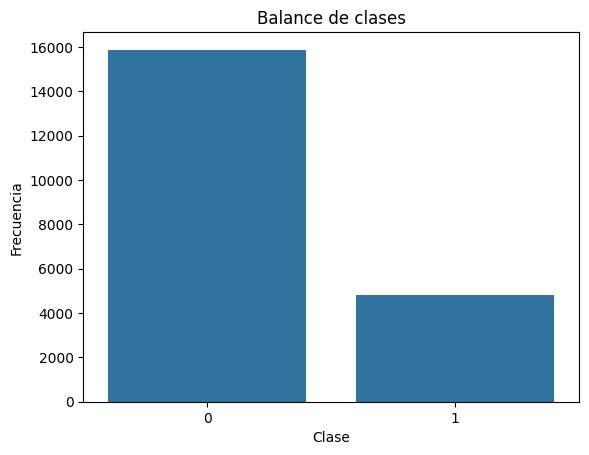

In [71]:
#vamos a ver si el dataset está balanceado o no
frecuencia_clases = df_train['RainTomorrow'].value_counts()

# Crea el gráfico de barras
sns.barplot(x=frecuencia_clases.index, y=frecuencia_clases.values)

# Añade etiquetas
plt.title('Balance de clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')

Vemos que los datos están desbalanceados

In [72]:
# vamos a sacar la variable estacion pq fue creada por noosotras y no la vamos a usar para el modelo
df_train = df_train.drop('Estacion', axis=1)
df_test = df_test.drop('Estacion', axis=1)

In [73]:
# Verificamos que hayan quedado ambos datsets con las mismas columnas
df_train.columns.any() == df_test.columns.any()

True

In [74]:
data_corr_1 = df_train.drop('RainTomorrow', axis=1)

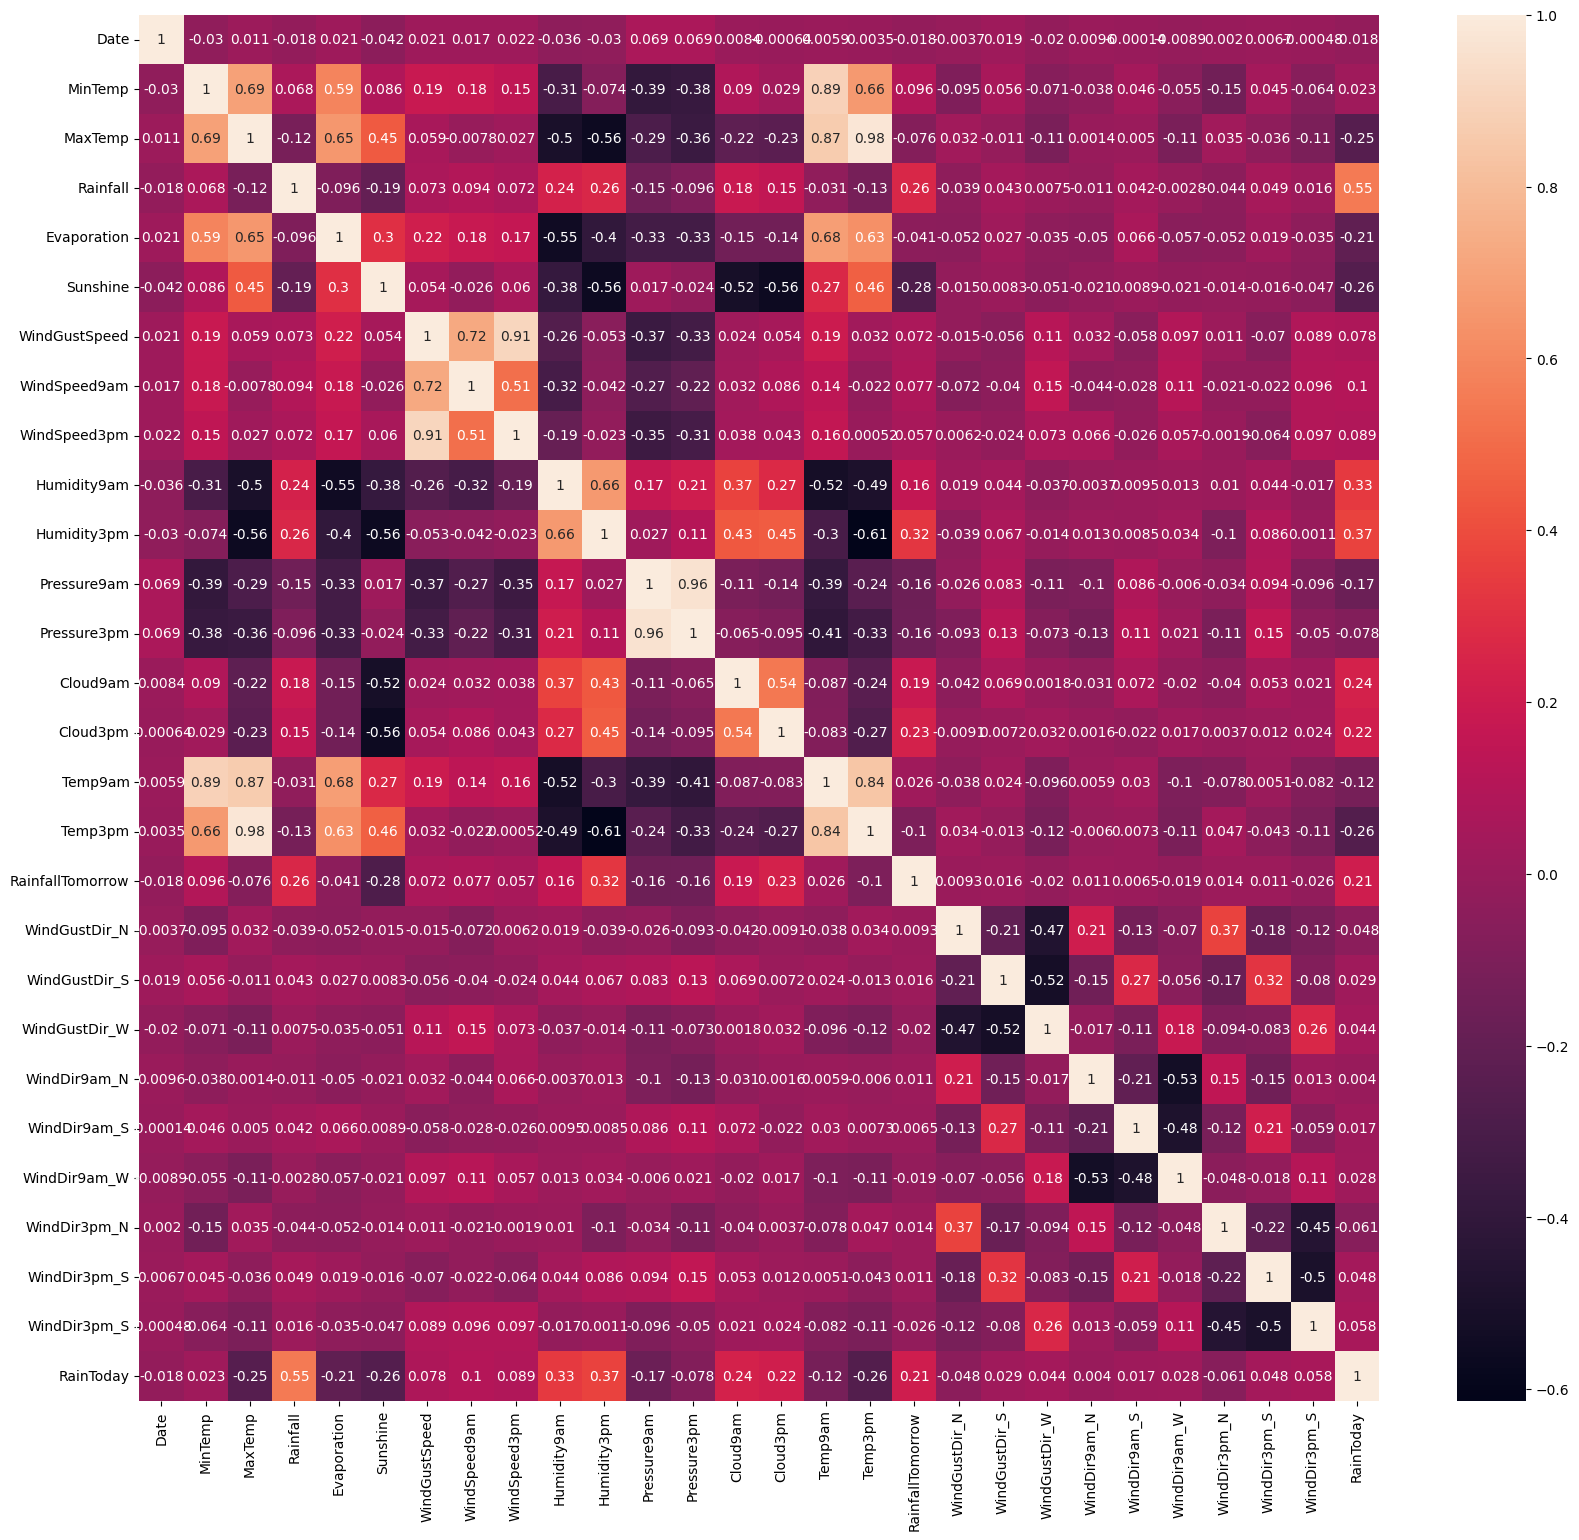

In [75]:
#vemos la matriz de correlación
plt.figure(figsize=(20,18))
sns.heatmap(data_corr_1.corr(), annot=True)
plt.show()


Vemos que hay algunas variables que tienen una gran correlación entre si, por ende vamos a dejar una sola variable que contemple ambas en los siguientes casos:
- maxTemp con Temp3pm (0.98)
- pressure9am con pressure3pm (0.96)
- WindGustSpeed con WindSpeed3pm (0.91)
- MinTemp con Temp9am (0.89)

Vamos a reacomodar estas variables y volver a ver como se relacionan con las que quedan

Text(0.5, 1.0, 'Relación de Pressure9am con Pressure3pm')

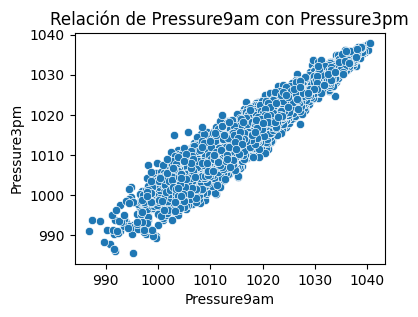

In [76]:
plt.figure(figsize=(4,3))
sns.scatterplot(data=df_train, x='Pressure9am', y='Pressure3pm')
plt.title('Relación de Pressure9am con Pressure3pm')

como las variables Pressure9am y Pressure3pm están muy relacionadas ya que es la presión medida en 2 horarios diferentes voy a generar una sola variable con estas (Pressure9am - Pressure3pm)

In [77]:
df_train['Pressure_Diff'] = df_train['Pressure9am'] - df_train['Pressure3pm']
df_train = df_train.drop('Pressure9am', axis =1)
df_train = df_train.drop('Pressure3pm', axis =1)

# Hacemos lo mismo para test porque los datasets tienen que tener las mismas variables
df_test['Pressure_Diff'] = df_test['Pressure9am'] - df_test['Pressure3pm']
df_test = df_test.drop('Pressure9am', axis =1)
df_test = df_test.drop('Pressure3pm', axis =1)

Text(0.5, 1.0, 'Relación de WindGustSpeed con WindSpeed3pm')

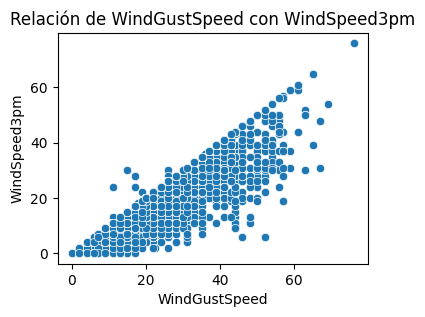

In [78]:
plt.figure(figsize=(4,3))
sns.scatterplot(data=df_train, x='WindGustSpeed', y='WindSpeed3pm')
plt.title('Relación de WindGustSpeed con WindSpeed3pm')

como estas son 2 mediciones diferentes (una es ráfaga de viento y la otra velocidad del viento) no vamos a juntar estas primero, sino que vamos a juntar WindSpeed3pm con Windspeed9am y vemos como se relaciona esa variable nueva con WindGustSpeed

In [79]:
df_train['WindSpeed_Diff'] = df_train['WindSpeed9am'] - df_train['WindSpeed3pm']
df_train = df_train.drop('WindSpeed9am', axis =1)
df_train = df_train.drop('WindSpeed3pm', axis =1)

# Lo repetimos para df_test
df_test['WindSpeed_Diff'] = df_test['WindSpeed9am'] - df_test['WindSpeed3pm']
df_test = df_test.drop('WindSpeed9am', axis =1)
df_test = df_test.drop('WindSpeed3pm', axis =1)

Text(0.5, 1.0, 'Relación de MaxTemp con Temp3pm')

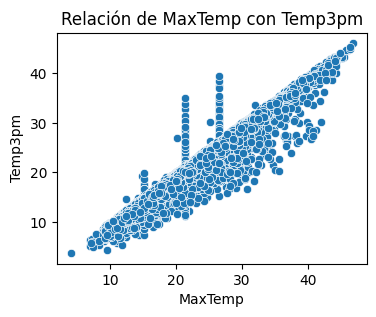

In [80]:
plt.figure(figsize=(4,3))
sns.scatterplot(data=df_train, x='MaxTemp', y='Temp3pm')
plt.title('Relación de MaxTemp con Temp3pm')

Text(0.5, 1.0, 'Relación de MixTemp con Temp9am')

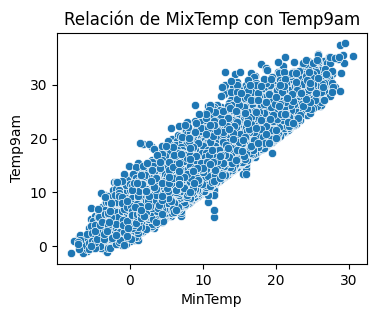

In [81]:
plt.figure(figsize=(4,3))
sns.scatterplot(data=df_train, x='MinTemp', y='Temp9am')
plt.title('Relación de MixTemp con Temp9am')

como las variables de las temperaturas están todas relacionadas vamos a crear 2 nuevas variables (MaxTemp - Min Temp) y (Temp3pm -Temp9am) ya que unas representan mediciones en un momento concreto para cada día y las otras las minimas y maximas de ese mismo día y vemos como se relacionan entre si.

In [82]:
df_train['MaxTemp_MinTemp_dif'] = df_train['MaxTemp'] - df_train['MinTemp']
df_train = df_train.drop('MaxTemp', axis =1)
df_train = df_train.drop('MinTemp', axis =1)

df_test['MaxTemp_MinTemp_dif'] = df_test['MaxTemp'] - df_test['MinTemp']
df_test = df_test.drop('MaxTemp', axis =1)
df_test = df_test.drop('MinTemp', axis =1)

In [83]:
df_train['Temp3pm_Temp9am_dif'] = df_train['Temp3pm'] - df_train['Temp9am']
df_train = df_train.drop('Temp3pm', axis =1)
df_train = df_train.drop('Temp9am', axis =1)

df_test['Temp3pm_Temp9am_dif'] = df_test['Temp3pm'] - df_test['Temp9am']
df_test = df_test.drop('Temp3pm', axis =1)
df_test = df_test.drop('Temp9am', axis =1)

In [84]:
#Vamos a juntar Humidity9am con Humidity3pm en una sola variable
df_train['Humidity_dif'] = df_train['Humidity9am'] - df_train['Humidity3pm']
df_train = df_train.drop('Humidity9am', axis =1)
df_train = df_train.drop('Humidity3pm', axis =1)

df_test['Humidity_dif'] = df_test['Humidity9am'] - df_test['Humidity3pm']
df_test = df_test.drop('Humidity9am', axis =1)
df_test = df_test.drop('Humidity3pm', axis =1)

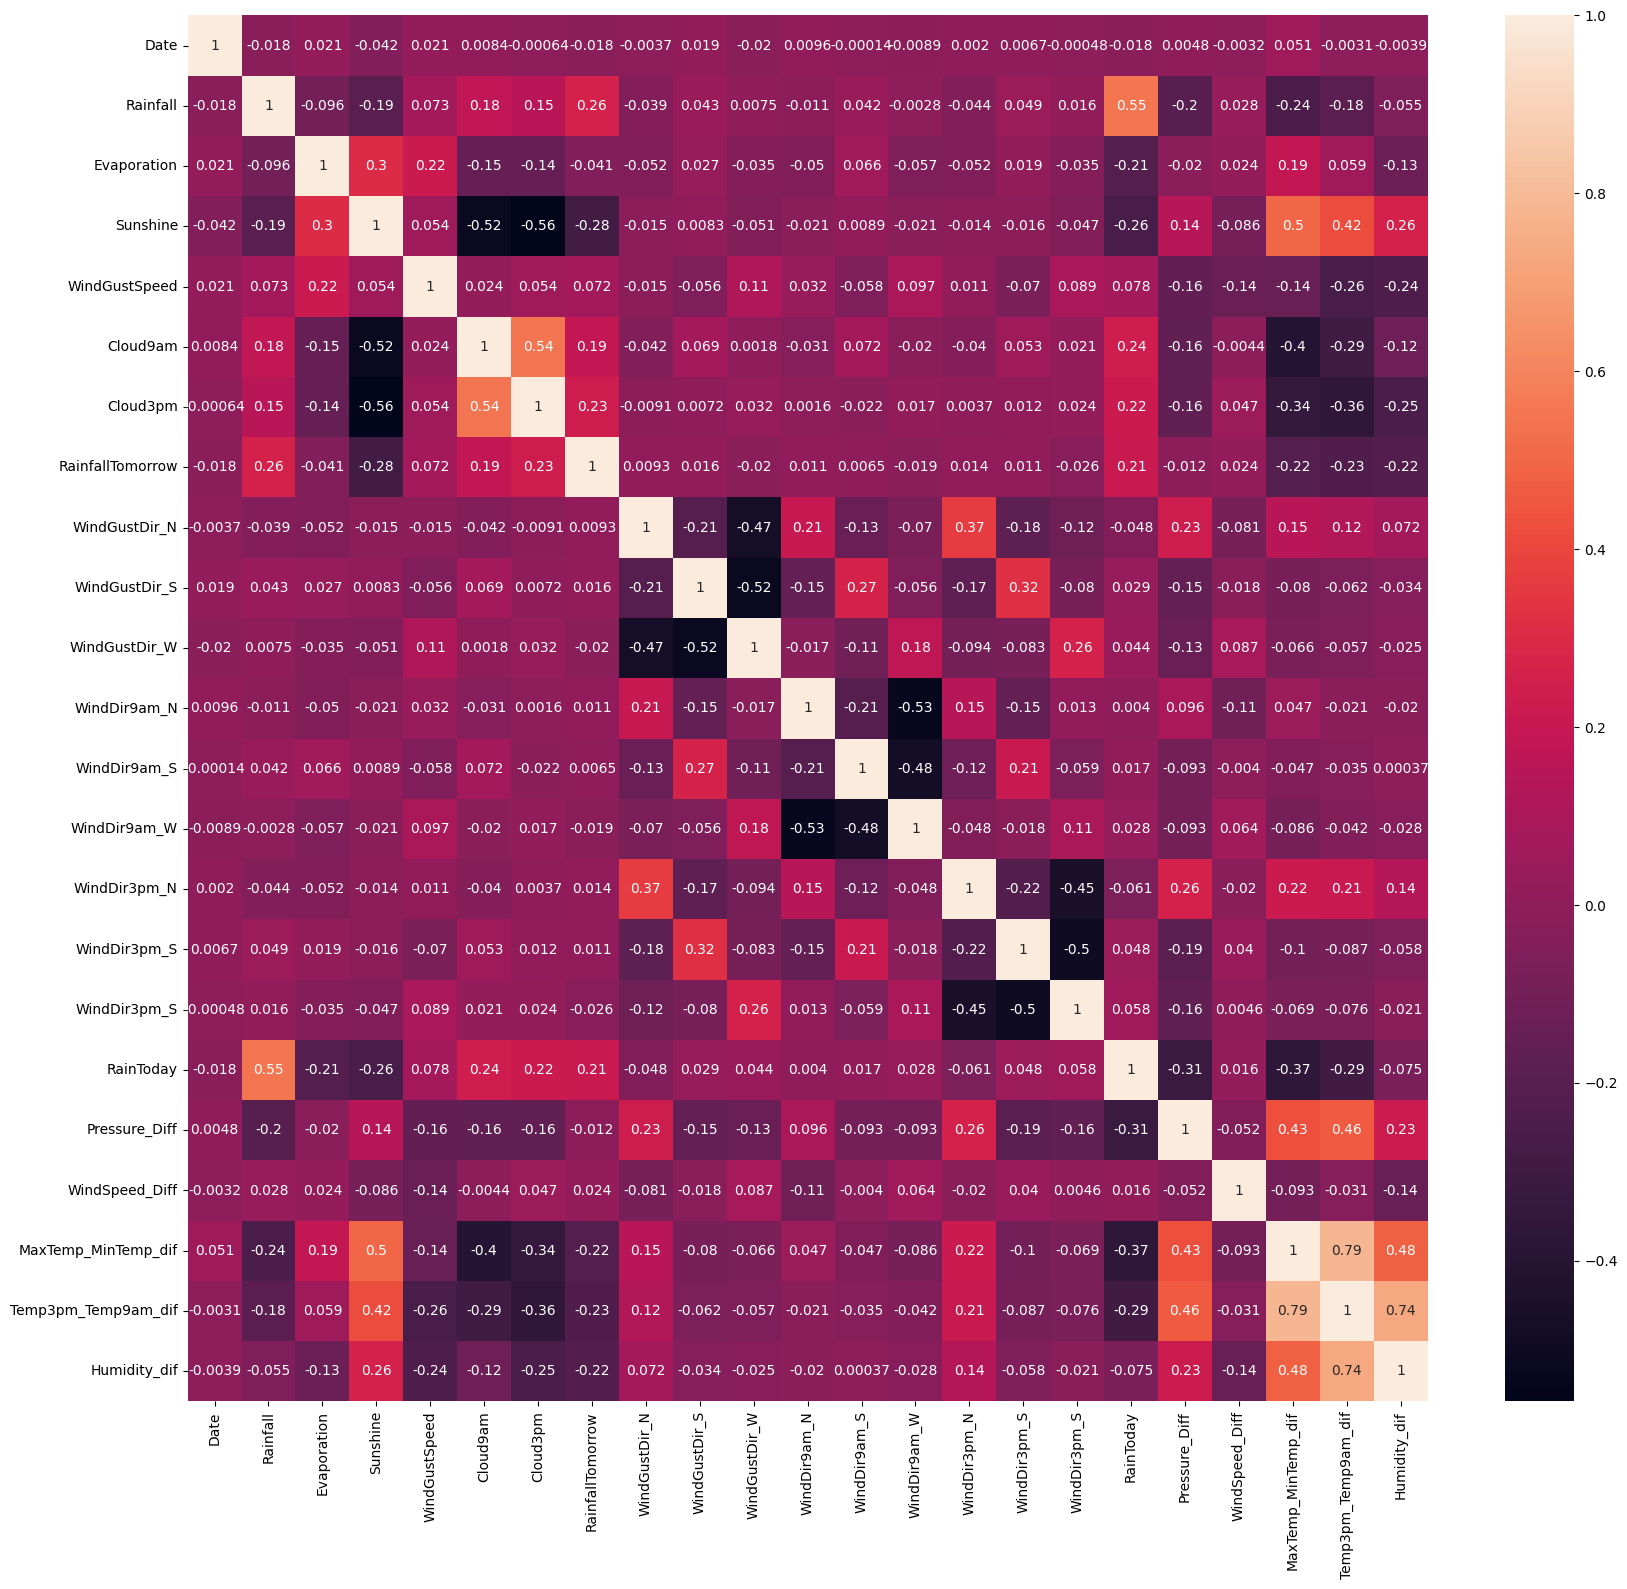

In [85]:
#vemos la matriz de correlación nuevamente, con las nuevas variables
data_corr_2 = df_train.drop('RainTomorrow', axis = 1)
plt.figure(figsize=(20,18))
sns.heatmap(data_corr_2.corr(), annot=True)
plt.show()

<Axes: xlabel='Temp3pm_Temp9am_dif', ylabel='MaxTemp_MinTemp_dif'>

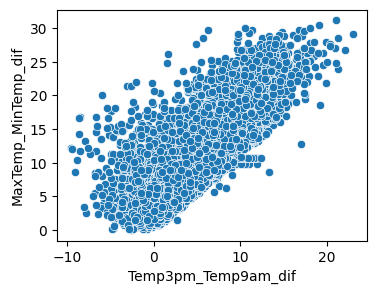

In [86]:
plt.figure(figsize=(4,3))
sns.scatterplot(data=df_train, x='Temp3pm_Temp9am_dif', y='MaxTemp_MinTemp_dif')

vamos a quedarnos con las 2 variables que tenemos de temperatura porque ese 0.21 que no está de correlacion lineal (1 - 0.89) puede aportar valor al modelo

# Estandarizacion

Estandarizamos los datos utilizando el método StandarScaler que calcula la media y la desviación estándar de los datos y luego aplica la transformación de estandarización. En definitiva hace esto: data_estandarizada = (data - media) / desviacion_estandar

In [87]:
# Lo aplicamos para df_train y df_test
scaler = StandardScaler() # Creamos el objeto scaler
df_scaled_train = scaler.fit_transform(df_train.drop(columns='Date', axis=1)) 
df_scaled_test = scaler.transform(df_test.drop(columns='Date', axis=1)) 

# Los convertimos a DataFrame porque si no son objetos de numpy
df_scaled_train = pd.DataFrame(df_scaled_train, columns=df_train.drop(columns='Date').columns)
df_scaled_test = pd.DataFrame(df_scaled_test, columns=df_test.drop(columns='Date').columns)

In [88]:
#vamos a generar otra base para usar en regresion logistica antes de eliminar raintomorrow
df_scaled_train2 = df_scaled_train.drop('RainfallTomorrow', axis=1)
df_scaled_test2 = df_scaled_test.drop('RainfallTomorrow', axis=1)

# Regresión Lineal

In [89]:
# La variable RainTomorrow la vamos a eliminar del modelo pq no puedo predecir cuanto llueve sabiendo si va a llover o no
df_scaled_train = df_scaled_train.drop('RainTomorrow', axis=1)
df_scaled_test = df_scaled_test.drop('RainTomorrow', axis=1)

In [90]:
# Preparamos los datos
x_train = df_scaled_train.drop(columns=['RainfallTomorrow'])  # características del conjunto de entrenamiento
y_train = df_scaled_train['RainfallTomorrow']  # variable objetivo del conjunto de entrenamiento

x_test = df_scaled_test.drop(columns=['RainfallTomorrow'])  # características del conjunto de prueba
y_test = df_scaled_test['RainfallTomorrow']  # variable objetivo del conjunto de prueba

In [91]:
# Regresion lineal con LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(x_train,y_train)
y_pred_train= lr.predict(x_train)
y_pred=lr.predict(x_test)

In [92]:
print("Coeficientes del modelo de regresión lineal:")
lr.coef_, lr.intercept_

Coeficientes del modelo de regresión lineal:


(array([ 0.18722739,  0.02867027, -0.16102258,  0.03494237,  0.00913059,
         0.06991942, -0.00250783,  0.01434873, -0.00905437, -0.03434725,
        -0.02138811, -0.04346891,  0.01160736, -0.00470025, -0.01965983,
         0.07571508,  0.13086897, -0.00952249, -0.00623882, -0.02902026,
        -0.14313988]),
 5.6564819889984505e-18)

In [93]:
# Evaluamos el modelo con 3 distintas métricas: 
# R^2 score evalua que proporcion de la variabilidad de mis datos está siendo capturada por mi modelo 
# MSE mide la media de los errores al cuadrardo, pero es sensible a los ouliers
# MAE mide la media en valor absoludo de los errores, es menos sensible a los outliers. Y como tenemos variable con outliers también la ponemos para comparar con

# Calculamos MSE
mset = mean_squared_error(y_train, y_pred_train)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error train:", mset)
print("Mean Squared Error test:", mse)

# Calcular MAE
maet = mean_absolute_error(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error train:", maet)
print("Mean Absolute Error test:", mae)

# Calcular R^2
r2t = r2_score(y_train, y_pred_train)
r2 = r2_score(y_test, y_pred)
print("R^2 Score train:", r2t)
print("R^2 Score test:", r2)


Mean Squared Error train: 0.8319735214364803
Mean Squared Error test: 0.9961332885782066
Mean Absolute Error train: 0.4289281750297137
Mean Absolute Error test: 0.46777776179702546
R^2 Score train: 0.1680264785635197
R^2 Score test: 0.19347405859849198


Vemos las métricas para ambos conjuntos para poder evaluar si hay overfitting o no. En este caso, como los valores entre las métricas de train y test son parecidos podemos decir que no hay overfitting.

Parece que el modelo tiene outliers porque MSE y MAE son diferentes.

Analizando R2 nuestro modelo solo representa casi el 20% de la variabilidad de mis datos, por lo que creemos que no conseguimos un buen fitting.

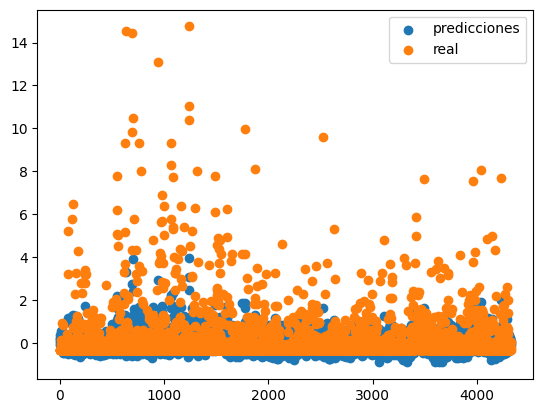

In [94]:
x=range(len(y_test))
plt.scatter(x, y=y_pred, label='predicciones')
plt.scatter(x, y=y_test, label='real')
plt.legend()
plt.show()

# Gradiente descendiente 

In [95]:
# Definimos la función de gradiente descendiente 

def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W) 
        error_test = y_test - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [96]:
# Hacemos un reshape de nuestra variable respuesta para que tenga eñl mismo formato que nuestra x
y_train_gd = y_train.values.reshape(-1,1)
y_test_gd = y_test.values.reshape(-1,1)

In [97]:
# Vemos que hayan quedado con el mismo formato
x_train.shape, y_train_gd.shape, x_test.shape, y_test_gd.shape

((20713, 21), (20713, 1), (4328, 21), (4328, 1))

In [98]:
# gradient_descent(x_train, y_train_gd, x_test, y_test_gd, lr=0.1, epochs=60)

In [99]:
# Función que calcula gradiente descendiente estocástico 
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

In [100]:
# stochastic_gradient_descent(x_train, y_train_gd, x_test, y_test_gd, lr=0.01, epochs=50)

El gradiente descendiente estocastico tarda demasiado tiempo en correr, por lo tanto vamos a usar gd mini-batch.

In [101]:
# Gradiente descendiente mini-batch 
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=144):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

In [102]:
# mini_batch_gradient_descent(x_train, y_train_gd, x_test, y_test_gd, lr=0.1, epochs=100, batch_size=11)

Si tenemos que decidir entre uno de los tres métodos, nos quedamos con mini-batch ya que es un punto medio entre los otros dos metodos anteriores

# Regularizacion

In [103]:
#Regularizacion con Lasso
y_train_r = y_train.values.reshape(-1,1)
lasso = Lasso(alpha=0.01)  # alpha controla la fuerza de la regularización L1 (Lasso)
lasso.fit(x_train, y_train_r)
print("Coeficientes del modelo Lasso:")
print(lasso.coef_)
print("R2 de train del modelo Lasso:", lasso.score(x_train,y_train_r))

Coeficientes del modelo Lasso:
[ 0.1827167   0.01539151 -0.15418705  0.02671652  0.0080097   0.06785893
 -0.          0.00067163 -0.01122962 -0.          0.         -0.00709155
  0.00048903 -0.         -0.01647919  0.0648014   0.1101897  -0.
 -0.         -0.02028282 -0.14085568]
R2 de train del modelo Lasso: 0.166285643989601


In [104]:
#Regularizacion con Ridge
ridge = Ridge(alpha=0.01)  # alpha controla la fuerza de la regularización L2 (Ridge)
ridge.fit(x_train, y_train_r)
print("Coeficientes del modelo Ridge:")
print(ridge.coef_)
print("R2 de train del modelo Ridge:", ridge.score(x_train, y_train_r))


Coeficientes del modelo Ridge:
[[ 0.18722729  0.02867024 -0.16102246  0.03494235  0.00913063  0.06991943
  -0.00250784  0.01434869 -0.0090544  -0.03434715 -0.02138803 -0.0434688
   0.01160737 -0.00470025 -0.01965983  0.07571507  0.13086888 -0.00952246
  -0.00623885 -0.02902033 -0.14313976]]
R2 de train del modelo Ridge: 0.16802647856348307


In [105]:
# Regularizacion con Elastic Net

elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5)
elasticnet.fit(x_train, y_train_r)
print("Coeficientes del modelo ElasticNet:")
print(elasticnet.coef_)
print("R2 de train del modelo ElasticNet:", elasticnet.score(x_train, y_train_r))

Coeficientes del modelo ElasticNet:
[ 0.18392161  0.02197767 -0.15641115  0.03049205  0.00918491  0.06929969
 -0.          0.00580064 -0.01089638 -0.00913308 -0.         -0.0156837
  0.00670182 -0.         -0.01672373  0.07026137  0.12050473 -0.00291179
 -0.00104497 -0.02702015 -0.14023387]
R2 de train del modelo ElasticNet: 0.1673460857708452


Vemos que las tres regularizaciones tienen las métricas parecidas, de hecho dan parecidas a la regresión (un poco mas bajo)

Como conclusion, los modelos que utilizamos hasta el momento no son buenos para ajustar nuestros datos. Veremos mas adelante...

# Parte 2

# Regresión Logística

In [106]:
def boxplots(X,y, columns):
  data = pd.concat([pd.DataFrame(y, columns=['RainTomorrow']), pd.DataFrame(X, columns=columns)], axis=1)

  num_features = X.shape[1]
  num_rows = num_features // 3 +1

  fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
  fig.subplots_adjust(hspace=0.5)

  # Se recorre cada feature para generar su diagrama de caja respecto de la salida
  for i, feature in enumerate(data.columns[1:]):
      row = i // 3
      col = i % 3
      sns.boxplot(x='RainTomorrow', y=feature, hue='RainTomorrow', data=data, ax=axes[row, col], palette=['blue', 'coral'], legend=False)
      axes[row, col].set_title(f'Diagrama de caja de {feature}')
      axes[row, col].set_xlabel('RainTomorrow')
      axes[row, col].set_ylabel(feature)
      axes[row, col].set_xticks([0, 1])
      axes[row, col].set_xticklabels(['No Lloverá', 'Lloverá'])

  # Eliminar subplots vacíos si es necesario
  if num_features % 3 != 0:
      for i in range(num_features % 3, 3):
          fig.delaxes(axes[num_rows - 1, i])

  plt.show()

In [107]:
eliminar = ['WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W',
       'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N',
       'WindDir3pm_S', 'WindDir3pm_S', 'RainToday', 'RainTomorrow']
feature_names=df_scaled_train2.drop(eliminar,axis=1).columns.values
feature_names


array(['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'Cloud9am',
       'Cloud3pm', 'Pressure_Diff', 'WindSpeed_Diff',
       'MaxTemp_MinTemp_dif', 'Temp3pm_Temp9am_dif', 'Humidity_dif'],
      dtype=object)

In [108]:
# Preparamos los datos para el boxplot
x_train2_boxplot = df_scaled_train2.drop(columns= eliminar)  # características del conjunto de entrenamiento
y_train2_boxplot = df_scaled_train2['RainTomorrow']  # variable objetivo del conjunto de entrenamiento


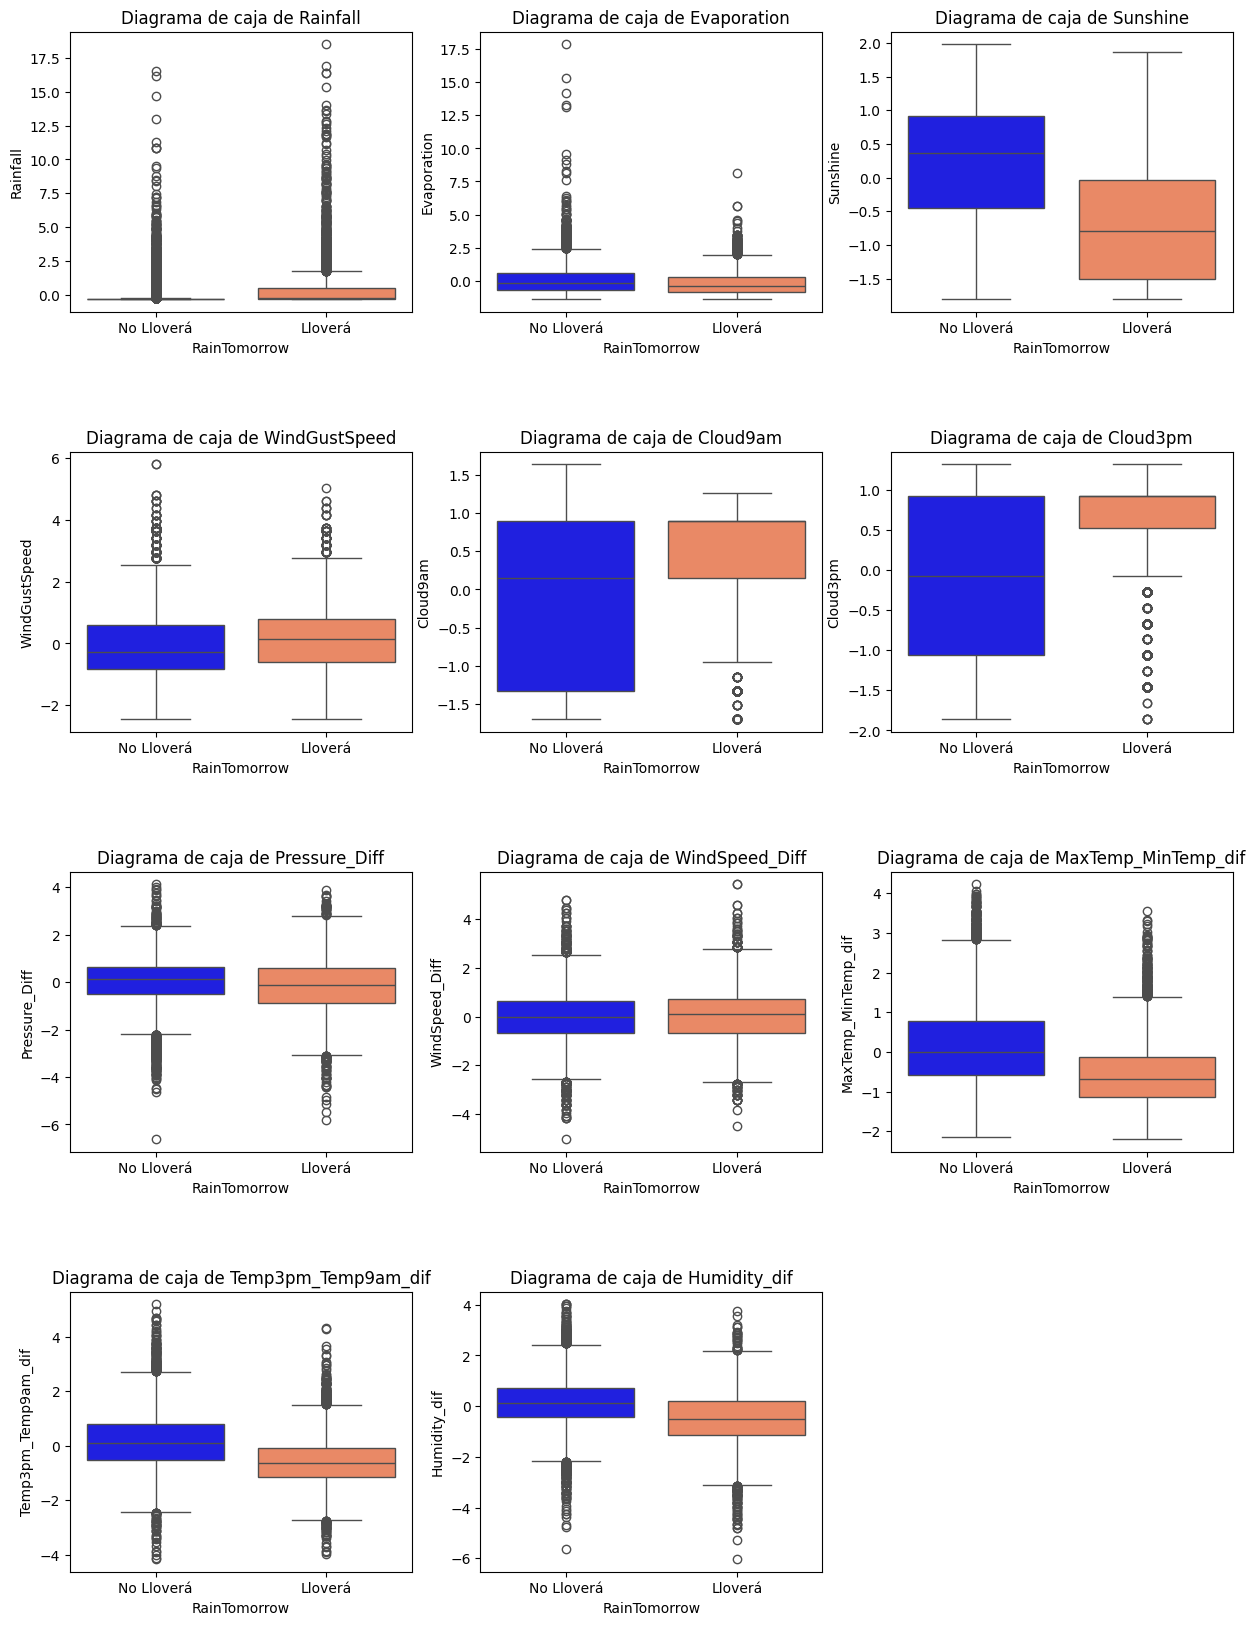

In [109]:
boxplots(x_train2_boxplot, y_train2_boxplot, feature_names)

Vemos que las variables que mas pueden influir son sunshine, cloud9am, cloud3pm, MaxTemp_MinTemp_dif, Temp3pm_Temp9am_dif, Humidity_dif. Si bien el resto de las variables no muestran una diferencia considerable entre ambas categorias, no vamos a descartarlas .

In [110]:
# Preparamos los datos
df_scaled_train2['RainTomorrow'] = df_scaled_train2['RainTomorrow'].apply(lambda x: 0 if x <= 0 else 1)
df_scaled_test2['RainTomorrow'] = df_scaled_test2['RainTomorrow'].apply(lambda x: 0 if x <= 0 else 1)

x_train2 = df_scaled_train2.drop(columns= ['RainTomorrow'])  # características del conjunto de entrenamiento
y_train2 = df_scaled_train2['RainTomorrow'] # variable objetivo del conjunto de entrenamiento

x_test2 = df_scaled_test2.drop(columns=['RainTomorrow'])  # características del conjunto de prueba
y_test2 = df_scaled_test2['RainTomorrow']  # variable objetivo del conjunto de prueba

Resultados con regresión logística en el conjunto de entrenamiento

              precision    recall  f1-score   support

           0       0.91      0.74      0.82     15882
           1       0.47      0.76      0.58      4831

    accuracy                           0.75     20713
   macro avg       0.69      0.75      0.70     20713
weighted avg       0.81      0.75      0.76     20713

accuracy balanceado: 0.7505136724160388
Perdida logarítmica: 9.128808269169534


<Axes: >

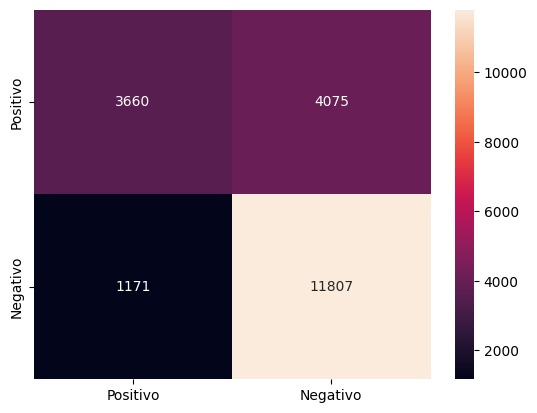

In [111]:
logistic_model = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model.fit(x_train2, y_train2)
y_pred_train2 = logistic_model.predict(x_train2)
y_pred2 = logistic_model.predict(x_test2)
balanced_accuracy = balanced_accuracy_score(y_train2, y_pred_train2)
loss = log_loss(y_train2, y_pred_train2)

print("Resultados con regresión logística en el conjunto de entrenamiento\n")
print(classification_report(y_train2, y_pred_train2))
print("accuracy balanceado:", balanced_accuracy)
print("Perdida logarítmica:", loss)

# Creamos la matriz de confusion siguiendo este orden [tp, fp, fn, tn]
tn, fp, fn, tp = confusion_matrix(y_train2, y_pred_train2).ravel()
confusion_mat = [[tp, fp],[fn, tn]]

# Y la graficamos con un heatmap para que se vea bien 
df_cm = pd.DataFrame(confusion_mat, index=['Positivo', 'Negativo'],
                     columns=['Positivo', 'Negativo'])
sns.heatmap(df_cm, annot=True, fmt='d')


Resultados con regresión logística en el conjunto de prueba

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      3271
           1       0.48      0.75      0.58      1057

    accuracy                           0.74      4328
   macro avg       0.69      0.74      0.70      4328
weighted avg       0.80      0.74      0.76      4328

accuracy balanceado: 0.7428812357788854
Perdida logarítmica: 9.38567406874654


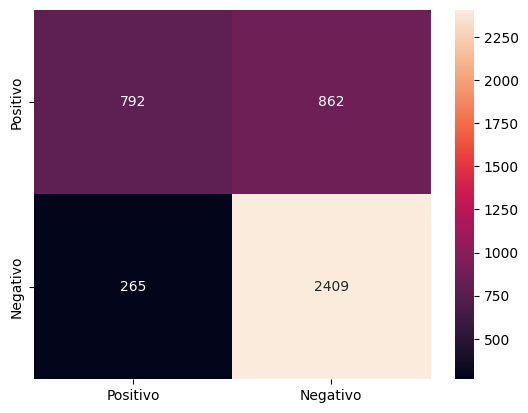

In [112]:
print("Resultados con regresión logística en el conjunto de prueba\n")
print(classification_report(y_test2, y_pred2))
balanced_accuracy = balanced_accuracy_score(y_test2, y_pred2)

# Creamos la matriz de confusion siguiendo este orden [tp, fp, fn, tn]
tn, fp, fn, tp = confusion_matrix(y_test2, y_pred2).ravel()
confusion_mat = [[tp, fp],[fn, tn]]
loss = log_loss(y_test2, y_pred2)


# Y la graficamos con un heatmap para que se vea bien 
df_cm = pd.DataFrame(confusion_mat, index=['Positivo', 'Negativo'],
                     columns=['Positivo', 'Negativo'])
sns.heatmap(df_cm, annot=True, fmt='d')
print("accuracy balanceado:", balanced_accuracy)
print("Perdida logarítmica:", loss)


En este caso nuestra clase positiva es que llueva. 

**Para el conjunto de entrenamiento**

Tenemos 4075 falsos positivos (o error del tipo 1) es decir, predije que llovía pero no llovió.
Tenemos 1171 falsos negativos (o error de tipo 2) es decir, predije que no llovía y llovió

**Para el conjunto de prueba**

Tenemos 862 falsos positivos (o error del tipo 1) es decir, predije que llovía pero no llovió.
Tenemos 265 falsos negativos (o error de tipo 2) es decir, predije que no llovía y llovió

En cuanto a las métricas vamos a utilizar el **F1 score** ya que como no somos agrónomas no podemos determinar cual de los dos errores tiene mayor importancia. Además nuestros datos están desbalanceados y esta métrica lo contempla.

F1 score para la clase positiva (en nuestro caso, si llueve) es de 0.48 lo que indicaría que el modelo no es muy bueno para clasificar correctamente esta clase.

En cambio, para la clase negativa (no llueve) el F1 score es de 0.81, lo que indica que si es bueno para predecir esta clase. 



log_loss cuantifica qué tan bien el modelo está prediciendo la probabilidad de que una muestra pertenezca a la clase positiva o negativa. Un valor de pérdida logarítmica más bajo indica un mejor rendimiento del modelo.

### Curva ROC

In [113]:
# Obtengo las probabilidades de predicción del modelo para los datos de entrenamiento y prueba
y_probs_train = logistic_model.predict_proba(x_train2)[:, 1]
y_probs_test = logistic_model.predict_proba(x_test2)[:, 1]

# Calculo la ROC y el AUC para los datos de entrenamiento y prueba
fpr_train, tpr_train, thresholds_train = roc_curve(y_train2, y_probs_train, pos_label= 1)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test2, y_probs_test, pos_label= 1)
roc_auc_test = auc(fpr_test, tpr_test)

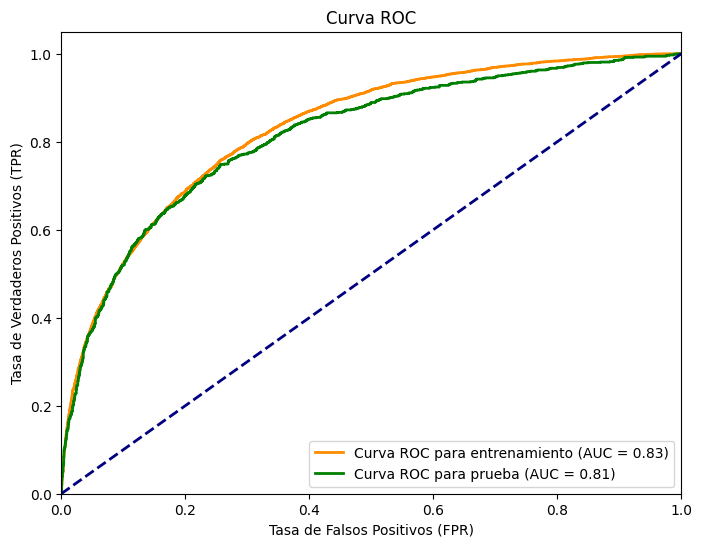

El área bajo la curva para entrenamiento es de: 0.8296700352013925
El área bajo la curva para prueba es de: 0.8143312102831946


In [114]:
# Grafico la curva ROC para los datos de entrenamiento y prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Curva ROC para entrenamiento (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Curva ROC para prueba (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print(f"El área bajo la curva para entrenamiento es de: {roc_auc_train}")
print(f"El área bajo la curva para prueba es de: {roc_auc_test}")

Calculamos cual es el umbral que minimiza la distancia al punto (0,1), que sería el mejor umbral

In [115]:
# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de entrenamiento
distances_train = np.sqrt((1 - tpr_train)**2 + fpr_train**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de entrenamiento
min_index_train = np.argmin(distances_train)

# Obtiene el umbral óptimo para los datos de entrenamiento
optimal_threshold_train = thresholds_train[min_index_train]

# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de prueba
distances_test = np.sqrt((1 - tpr_test)**2 + fpr_test**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de prueba
min_index_test = np.argmin(distances_test)

# Obtiene el umbral óptimo para los datos de prueba
optimal_threshold_test = thresholds_test[min_index_test]

print("Umbral óptimo para entrenamiento:", optimal_threshold_train)
print("Umbral óptimo para prueba:", optimal_threshold_test)


Umbral óptimo para entrenamiento: 0.5004850655706763
Umbral óptimo para prueba: 0.5046782214883877


Nos dimos cuenta que el umbral óptimo si está cerca del 0.5 

## Modelos Base

#### Modelo base Regresión

Para el modelo base de regresión vamos a tomar una sola variable explicativa y con esa aplicamos el modelo.
La elegimos mirando la matriz de correlación y vamos a elegir la variable Rainfall ya que es la que está mas correlacionada con RainfallTomorrow.

In [116]:
# Preparamos los datos
x_train_base_r = df_scaled_train['Rainfall']  # características del conjunto de entrenamiento
y_train_base_r = df_scaled_train['RainfallTomorrow'] # variable objetivo del conjunto de entrenamiento

x_test_base_r = df_scaled_test['Rainfall']   # características del conjunto de prueba
y_test_base_r = df_scaled_test['RainfallTomorrow']  # variable objetivo del conjunto de prueba

In [117]:
# Regresion lineal con LinearRegression
lr_base = LinearRegression(fit_intercept=True)
lr_base.fit(x_train_base_r.values.reshape(-1, 1),y_train_base_r)
y_pred_train_base_r= lr_base.predict(x_train_base_r.values.reshape(-1, 1))
y_pred_base_r=lr_base.predict(x_test_base_r.values.reshape(-1, 1))

In [118]:
# Calculamos MSE
mset = mean_squared_error(y_train_base_r, y_pred_train)
mse = mean_squared_error(y_test_base_r, y_pred_base_r)
print("Mean Squared Error train:", mset)
print("Mean Squared Error test:", mse)

# Calcular MAE
maet = mean_absolute_error(y_train_base_r, y_pred_train_base_r)
mae = mean_absolute_error(y_test_base_r, y_pred_base_r)
print("Mean Absolute Error train:", maet)
print("Mean Absolute Error test:", mae)

# Calcular R^2
r2t = r2_score(y_train_base_r, y_pred_train_base_r)
r2 = r2_score(y_test_base_r, y_pred_base_r)
print("R^2 Score train:", r2t)
print("R^2 Score test:", r2)


Mean Squared Error train: 0.8319735214364803
Mean Squared Error test: 1.12420118570803
Mean Absolute Error train: 0.4427857626422627
Mean Absolute Error test: 0.4808703899714033
R^2 Score train: 0.06716980922095617
R^2 Score test: 0.08978303403352672


Como es un modelo base no se ajusta bien a los datos tal cual esperabamos

#### Modelo base Clasificación

Al igual que para el modelo base de regresión nos vamos a quedar con una sola variable explicativa, en este caso Raintoday

In [119]:
# Preparamos los datos
x_train2_base_c = df_scaled_train2['RainToday']  # características del conjunto de entrenamiento
y_train2_base_c = df_scaled_train2['RainTomorrow'] # variable objetivo del conjunto de entrenamiento

x_test2_base_c = df_scaled_test2['RainToday']  # características del conjunto de prueba
y_test2_base_c = df_scaled_test2['RainTomorrow']  # variable objetivo del conjunto de prueba

In [120]:
logistic_model_base_c = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model_base_c.fit(x_train2_base_c.values.reshape(-1, 1), y_train2_base_c)
y_pred_train2_base_c = logistic_model_base_c.predict(x_train2_base_c.values.reshape(-1, 1))
y_pred2_base_c = logistic_model_base_c.predict(x_test2_base_c.values.reshape(-1, 1))

print("Resultados con regresión logística en el conjunto de entrenamiento\n")
print(classification_report(y_train2_base_c, y_pred_train2_base_c))


print("Resultados con regresión logística en el conjunto de prueba\n")
print(classification_report(y_test2_base_c, y_pred2_base_c))

Resultados con regresión logística en el conjunto de entrenamiento

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     15882
           1       0.45      0.45      0.45      4831

    accuracy                           0.74     20713
   macro avg       0.64      0.64      0.64     20713
weighted avg       0.74      0.74      0.74     20713

Resultados con regresión logística en el conjunto de prueba

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3271
           1       0.45      0.45      0.45      1057

    accuracy                           0.73      4328
   macro avg       0.64      0.64      0.64      4328
weighted avg       0.73      0.73      0.73      4328



Como era de esperar el modelo es bastante malo para predecir ya que su recall para "si llueve" es 0.45, es decir de las que efectivamente llovió solo predijo bien el 45%.

Lo mismo para la precisión de las que clasificó como "llueve" solo el 45% realmente llovió.

## Optimizar hiperparámetros

#### Validación cruzada K Folds

##### Clasificación

In [121]:
# Definimos un bosque aleatorio para clasificación 
clf = RandomForestClassifier(n_estimators=50, random_state=42)

In [122]:
# Dividimos los datos en train y validation
# Vamos a tomar como validacion el 10% de nuestros datos de entrenamiento
x_train_k, x_val_k, y_train_k, y_val_k = train_test_split(x_train2, y_train2, test_size=0.1, random_state=42)

In [123]:
# Asignamos 5 folds  
cv_strategies = [
    ("KFold", KFold(n_splits=5, shuffle=True, random_state=42)),
    ("StratifiedKFold", StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
]

results = {}
for name, cv in cv_strategies:
    scores = cross_val_score(clf, x_val_k, y_val_k, cv=cv)
    results[name] = scores

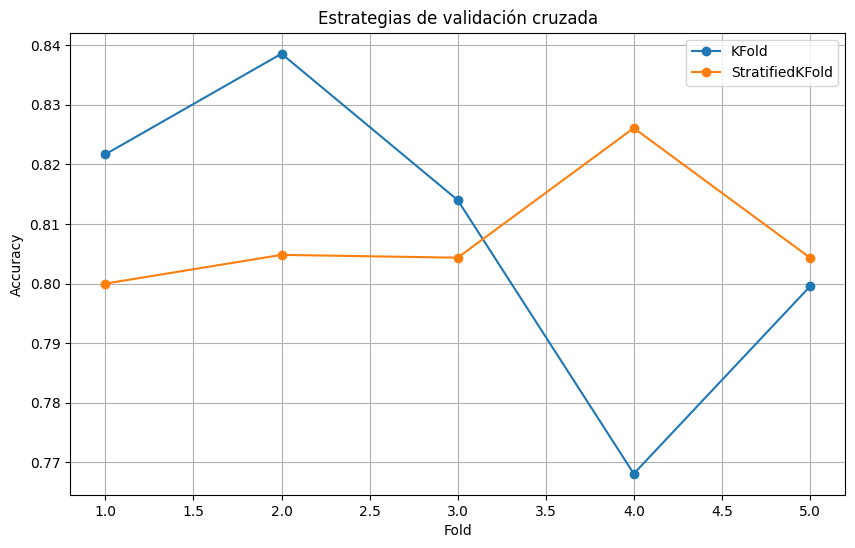

In [124]:
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()

In [125]:
print("Accuracy para cada K-Fold: ", results['KFold'])
print("Accuracy para cada StratifiedKFold: ", results['StratifiedKFold'])

Accuracy para cada K-Fold:  [0.82168675 0.83855422 0.81400966 0.76811594 0.79951691]
Accuracy para cada StratifiedKFold:  [0.8        0.80481928 0.80434783 0.82608696 0.80434783]


In [126]:
for strategy in cv_strategies:
  print('Media para la estrategia', strategy[0],':',results[strategy[0]].mean())
  print('Desvío estándar para la estrategia', strategy[0],':',results[strategy[0]].std())

Media para la estrategia KFold : 0.8083766951865432
Desvío estándar para la estrategia KFold : 0.0237444506235381
Media para la estrategia StratifiedKFold : 0.8079203771608171
Desvío estándar para la estrategia StratifiedKFold : 0.009250946372472901


Comparando los modelos: si bien ambos tienen igual media y std (lo que puede ayudarnos a saber que el modelo no está overfitteando), en el gráfico podemos observar que K-Folds tiene mayor varianza que StratifiedKFold, eso se debe a que K-Folds separa sus folds aleatoriamente, en cambio StratifiedKFold trata de balancearlos. 

Como sabemos que nuestro dataset está desbalanceado, tenderíamos a quedarnos con StratifiedKFold.

#### Grid, Random Search, Optuna

##### Clasificación

In [127]:
# Creamos el clasificador RandomForestClassifier
lr = LogisticRegression(random_state=42)

In [128]:
### Para cada hiperparámetro se chequean las métricas de Precisión y Recall.
#scores = ["precision", "recall", ]

In [129]:
# def print_dataframe(filtered_cv_results):
#     ### print de los resultados de cross validation
#     for mean_precision, std_precision, mean_recall, std_recall, params in zip(
#         filtered_cv_results["mean_test_precision"],
#         filtered_cv_results["std_test_precision"],
#         filtered_cv_results["mean_test_recall"],
#         filtered_cv_results["std_test_recall"],
#         filtered_cv_results["params"],
#     ):
#         print(
#             f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
#             f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
#             f" for {params}"
#         )
#     print()

# def refit_strategy(cv_results):
#     """Define the strategy to select the best estimator.

#     The strategy defined here is to filter-out all results below a precision threshold
#     of 0.7, rank the remaining by recall and keep all models with one standard
#     deviation of the best by recall. Once these models are selected, we can select the
#     fastest model to predict.

#     Parameters
#     ----------
#     cv_results : dict of numpy (masked) ndarrays
#         CV results as returned by the `GridSearchCV`.

#     Returns
#     -------
#     best_index : int
#         The index of the best estimator as it appears in `cv_results`.
#     """
#     # print the info about the grid-search for the different scores
#     precision_threshold = 0.7

#     cv_results_ = pd.DataFrame(cv_results)
#     print("All grid-search results:")
#     print_dataframe(cv_results_)

#     # Filter-out all results below the threshold
#     high_precision_cv_results = cv_results_[
#         cv_results_["mean_test_precision"] > precision_threshold
#     ]

#     print(f"Models with a precision higher than {precision_threshold}:")
#     print_dataframe(high_precision_cv_results)

#     high_precision_cv_results = high_precision_cv_results[
#         [
#             "mean_score_time",
#             "mean_test_recall",
#             "std_test_recall",
#             "mean_test_precision",
#             "std_test_precision",
#             "rank_test_recall",
#             "rank_test_precision",
#             "params",
#         ]
#     ]

#     # Select the most performant models in terms of recall
#     # (within 1 sigma from the best)
#     best_recall_std = high_precision_cv_results["mean_test_recall"].std()
#     best_recall = high_precision_cv_results["mean_test_recall"].max()
#     best_recall_threshold = best_recall - best_recall_std

#     high_recall_cv_results = high_precision_cv_results[
#         high_precision_cv_results["mean_test_recall"] > best_recall_threshold
#     ]
#     print(
#         "Out of the previously selected high precision models, we keep all the\n"
#         "the models within one standard deviation of the highest recall model:"
#     )
#     print_dataframe(high_recall_cv_results)

#     # From the best candidates, select the fastest model to predict
#     fastest_top_recall_high_precision_index = high_recall_cv_results[
#         "mean_score_time"
#     ].idxmin()

#     print(
#         "\nThe selected final model is the fastest to predict out of the previously\n"
#         "selected subset of best models based on precision and recall.\n"
#         "Its scoring time is:\n\n"
#         f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
#     )

#     return fastest_top_recall_high_precision_index

In [130]:
refit_strategy = 'f1_weighted'
scores = 'f1_weighted'

In [131]:
# Definimos los parámetros para Grid Search
tuned_parameters = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10,100], "solver": ['newton-cg'], "max_iter": [200, 500]}
]

# Realizamos la búsqueda de hiperparámetros con Grid Search
grid_search = GridSearchCV(estimator=lr, param_grid=tuned_parameters, scoring=scores, refit=refit_strategy)
start = time.time()
grid_search.fit(x_train_k, y_train_k)
end = time.time()
grid_search_time = end - start
y_pred_grid_search = grid_search.predict(x_val_k)

# Métricas para el modelo con Grid Search
grid_search_f1_score = f1_score(y_val_k, y_pred_grid_search, average='weighted')


print(f"Tiempo de Grid Search: {grid_search_time} segundos")
print(f"F1 Score del modelo con Grid Search: {grid_search_f1_score}")

Tiempo de Grid Search: 3.455413341522217 segundos
F1 Score del modelo con Grid Search: 0.7913368035037271


In [132]:
grid_search.best_params_

{'C': 10, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}

In [133]:
#  Random Search

# Realizamos la búsqueda de hiperparámetros con Random Search
random_search = RandomizedSearchCV(estimator=lr, param_distributions=tuned_parameters , scoring=scores, refit=refit_strategy)
start = time.time()
random_search.fit(x_train_k, y_train_k)
end = time.time()
random_search_time = end - start
y_pred_random_search = random_search.predict(x_val_k)

# Métricas para el modelo con Random Search
random_search_f1_score = f1_score(y_val_k, y_pred_random_search, average='weighted')

print(f"Tiempo de Random Search: {random_search_time} segundos")
print(f"F1 Score del modelo con random Search: {random_search_f1_score}")


Tiempo de Random Search: 2.0491621494293213 segundos
F1 Score del modelo con random Search: 0.7913368035037271


In [134]:
random_search.best_params_

{'solver': 'newton-cg', 'max_iter': 500, 'class_weight': None, 'C': 10}

In [135]:
# Entrenamos el modelo sin optimización de hiperparámetros
start = time.time()
lr.fit(x_train_k, y_train_k)
end = time.time()
no_opt_time = end - start
y_pred_no_opt = lr.predict(x_val_k)
default_params = lr.get_params()

# Métricas para el modelo sin optimización
no_opt_f1_score = f1_score(y_val_k, y_pred_no_opt, average='weighted')

print(f"F1 Score del modelo sin optimización: {no_opt_f1_score}")


F1 Score del modelo sin optimización: 0.7913368035037271


In [136]:
default_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [137]:
# Creamos una tabla comparativa
results = pd.DataFrame({
    'Modelo': ['Sin Optimización', 'Grid Search', 'Random Search'],
    'Tiempo de Entrenamiento (s)': [no_opt_time, grid_search_time, random_search_time],
})

# Aplicar formato a la tabla
styled_results = results.style.format({
    'Tiempo de Entrenamiento (s)': "{:.2f}"
})

# Imprimir la tabla
styled_results.set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}])

,Modelo,Tiempo de Entrenamiento (s)
0,Sin Optimización,0.03
1,Grid Search,3.46
2,Random Search,2.05


In [138]:
# # Creamos una tabla comparativa para los modelos de comparacion
# results = pd.DataFrame({
#     'Modelo': ['Sin Optimización', 'Grid Search', 'Random Search'],
#     'F1 Score': [no_opt_f1_score, grid_search_f1_score, random_search_f1_score],
#     'n_estimators': [default_params['n_estimators'], grid_search.best_params_['n_estimators'], random_search.best_params_['n_estimators']],
#     'max_depth': [default_params['max_depth'], grid_search.best_params_['max_depth'], random_search.best_params_['max_depth']],
#     'min_samples_split': [default_params['min_samples_split'], grid_search.best_params_['min_samples_split'], random_search.best_params_['min_samples_split']],
#     'min_samples_leaf': [default_params['min_samples_leaf'], grid_search.best_params_['min_samples_leaf'], random_search.best_params_['min_samples_leaf']]
# })

# # Convertir a tipo entero
# results['n_estimators'] = results['n_estimators'].astype('Int64')
# results['max_depth'] = results['max_depth'].astype('Int64')
# results['min_samples_split'] = results['min_samples_split'].astype('Int64')
# results['min_samples_leaf'] = results['min_samples_leaf'].astype('Int64')

# # Aplicar formato a la tabla
# styled_results = results.style.format({
#     'F1 Score': "{:.4f}",
# })

# # Ajustar la alineación de las celdas
# styled_results = styled_results.set_properties(**{'text-align': 'center'}).set_table_styles([{
#     'selector': 'th',
#     'props': [('text-align', 'center')]
# }])

# # Mostrar la tabla
# styled_results

Utilizamos para evaluar nuestros modelos la metrica F1 Score, para ser consistentes con lo que decidimos en nuestro modelo original

Como podemos ver, la métrica que estamos evaluando no cambia significativamente entre las diferentes optimizaciones de hiperparametros, incluso en el modelo que no tiene optimización de hiperparámetros.

Por este motivo, vamos a utilizar como seleccion de hiperparámetros a random search, ya que tarda mucho menos tiempo que grid search.

##### Regresión

In [139]:
# # Creamos el clasificador RandomForestRegressor
# rf_r = RandomForestRegressor(random_state=42)

In [140]:
# # Dividimos los datos en train y validation
# # Vamos a tomar como validacion el 10% de nuestros datos de entrenamiento
# x_train_k_r, x_val_k_r, y_train_k_r, y_val_k_r = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [141]:
# # Grid search
# grid_params_r = {
#     'n_estimators': [100, 200],
#     'max_depth': [5, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search_r = GridSearchCV(rf_r, grid_params_r, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search_r.fit(x_train_k_r, y_train_k_r)
# best_grid_params_r = grid_search_r.best_params_
# best_grid_model_r = RandomForestRegressor(**best_grid_params_r, random_state=42)
# best_grid_model_r.fit(x_train_k_r, y_train_k_r)
# grid_search_mse_r = mean_squared_error(y_val_k_r, best_grid_model_r.predict(x_val_k_r))

In [142]:
# best_grid_params_r

In [143]:
# # Random search
# random_params_r = {
#     'n_estimators': [100, 200],
#     'max_depth': [5, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2, 4]
# }

# random_search_r = RandomizedSearchCV(rf_r, random_params_r, n_iter=4, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# random_search_r.fit(x_train_k_r, y_train_k_r)
# best_random_params_r = random_search_r.best_params_
# best_random_model_r = RandomForestRegressor(**best_random_params_r, random_state=42)
# best_random_model_r.fit(x_train_k_r, y_train_k_r)
# random_search_mse_r = mean_squared_error(y_val_k_r, best_random_model_r.predict(x_val_k_r))

In [144]:
# best_random_params_r

In [145]:
# # función para entrenar y evaluar un modelo con hiperparámetros dados
# def train_evaluate_model(params, X_train, y_train, X_test, y_test):
#     model = RandomForestRegressor(**params, random_state=42)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     return mse

In [146]:
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 100, 200)
#     max_depth = trial.suggest_int('max_depth', 5, 20)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

#     params = {
#         'n_estimators': n_estimators,
#         'max_depth': max_depth,
#         'min_samples_split': min_samples_split,
#         'min_samples_leaf': min_samples_leaf
#     }

#     mse = train_evaluate_model(params, x_train_k_r, y_train_k_r, x_val_k_r, y_val_k_r)
#     return mse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)
# best_optuna_params = study.best_params
# best_optuna_model = RandomForestRegressor(**best_optuna_params, random_state=42)
# best_optuna_model.fit(x_train_k, y_train_k)
# optuna_mse = mean_squared_error(y_val_k, best_optuna_model.predict(x_val_k))

In [147]:
# best_optuna_params

In [148]:
# # Creamos una tabla comparativa para el modelo de regresion
# results = pd.DataFrame({
#     'Modelo': ['Grid Search', 'Random Search', 'Optuna'],
#     'MSE': [grid_search_mse_r, random_search_mse_r, optuna_mse],
#     'n_estimators': [best_grid_params_r['n_estimators'], best_random_params_r['n_estimators'], best_optuna_params['n_estimators']],
#     'max_depth': [best_grid_params_r['max_depth'], best_random_params_r['max_depth'], best_optuna_params['max_depth']],
#     'min_samples_split': [best_grid_params_r['min_samples_split'], best_random_params_r['min_samples_split'], best_optuna_params['min_samples_split']],
#     'min_samples_leaf': [best_grid_params_r['min_samples_leaf'], best_random_params_r['min_samples_leaf'], best_optuna_params['min_samples_leaf']]
# })

# # Convertir a tipo entero
# results['n_estimators'] = results['n_estimators'].astype('Int64')
# results['max_depth'] = results['max_depth'].astype('Int64')
# results['min_samples_split'] = results['min_samples_split'].astype('Int64')
# results['min_samples_leaf'] = results['min_samples_leaf'].astype('Int64')

# # Aplicar formato a la tabla
# styled_results = results.style.format({
#     'MSE': "{:.4f}",
# })

# # Ajustar la alineación de las celdas
# styled_results = styled_results.set_properties(**{'text-align': 'center'}).set_table_styles([{
#     'selector': 'th',
#     'props': [('text-align', 'center')]
# }])

# # Mostrar la tabla
# styled_results

En esta tabla podemos observar la comparación de los hiperparámetros que se eligieron para cada modelo, y además la comparación de la métrica elegida (MSE para tener correlación con nuestro modelo original). 

Comparando el MSE de todos los modelos, vemos que la métrica es mucho mejor en Optuna que en los otros casos. 
Entonces nos quedamos con Optuna

## Explicabilidad SHAP


##### Explicabilidad Local regresión logística

In [149]:
# Crea un objeto explainer SHAP
feature_names=x_train2.columns.values
feature_names
explainer = shap.LinearExplainer(logistic_model, x_train2, feature_names=feature_names)

In [150]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(x_test2)

In [151]:
shap_values.shape

(4328, 21)

In [152]:
explainer.expected_value

-0.4755756550771904

In [153]:
index=0
logistic_model.predict_proba(x_test2)[index]
logistic_model.predict(x_test2)[index]

0

In [154]:
shap_values[index]

array([-0.06528818,  0.03093549,  0.50240638, -0.04360655,  0.02099218,
       -0.70976044, -0.05098977, -0.02214175,  0.09163348, -0.02721484,
        0.03762509,  0.02337311, -0.08680194, -0.03396276,  0.01098373,
       -0.18728738,  0.14988498, -0.13002601, -0.01658214, -0.06460176,
        0.1313648 ])

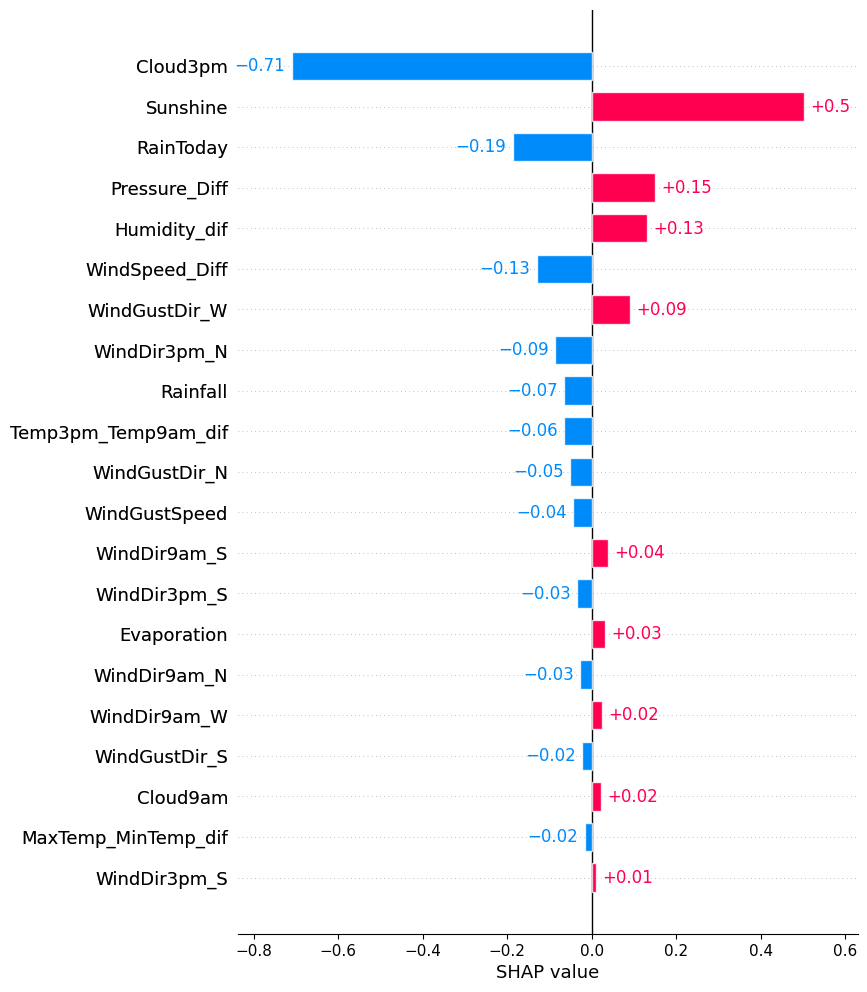

In [155]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.bar(explanation, max_display=21)

las variables que mas impactan en que llueva mañana a nivel local son cloud3pm y sunshine 

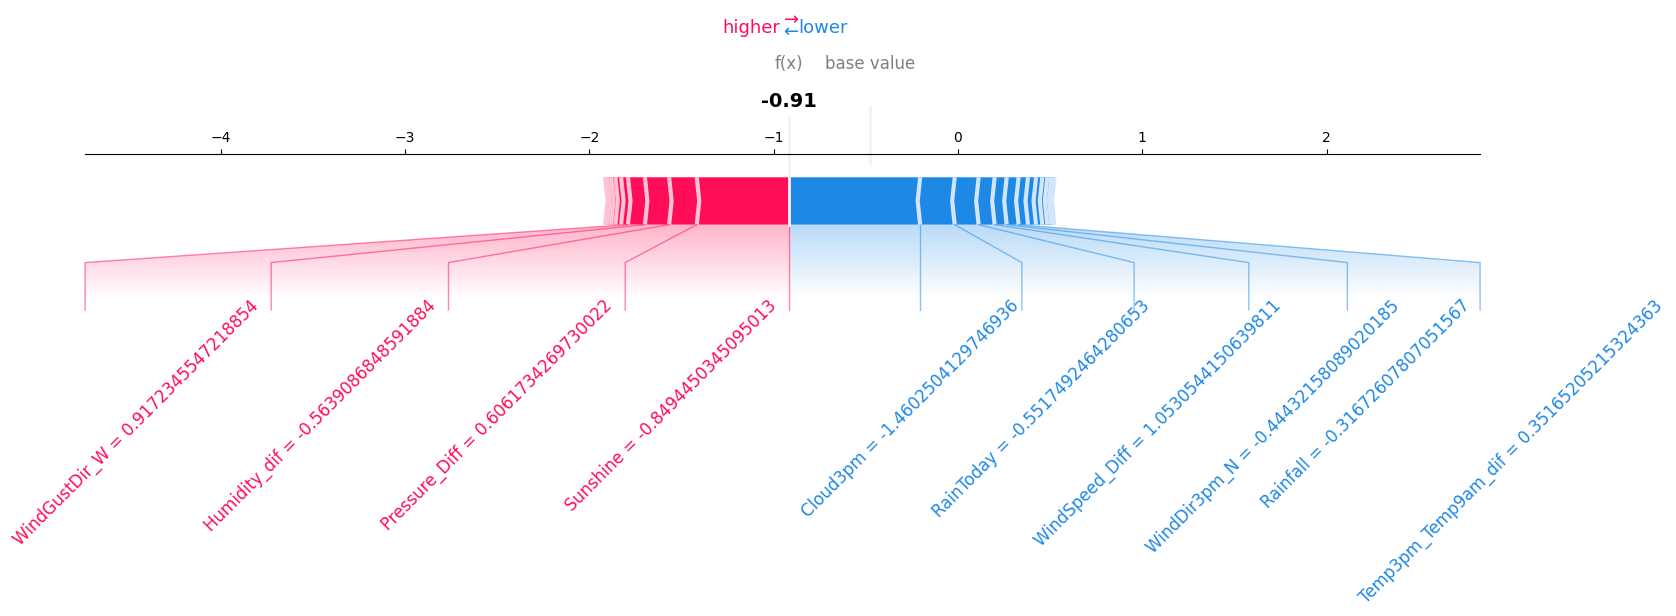

In [156]:
shap.force_plot(explainer.expected_value, shap_values[index], x_test2.loc[index], feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=45)

En este gráfico podemos observar que hay mas variables que empujan hacia mi clase negativa que hacía la positivs, de ahí que mi valor base sea negativo.

##### Explicabilidad Global regresión logística

In [157]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=x_test2)

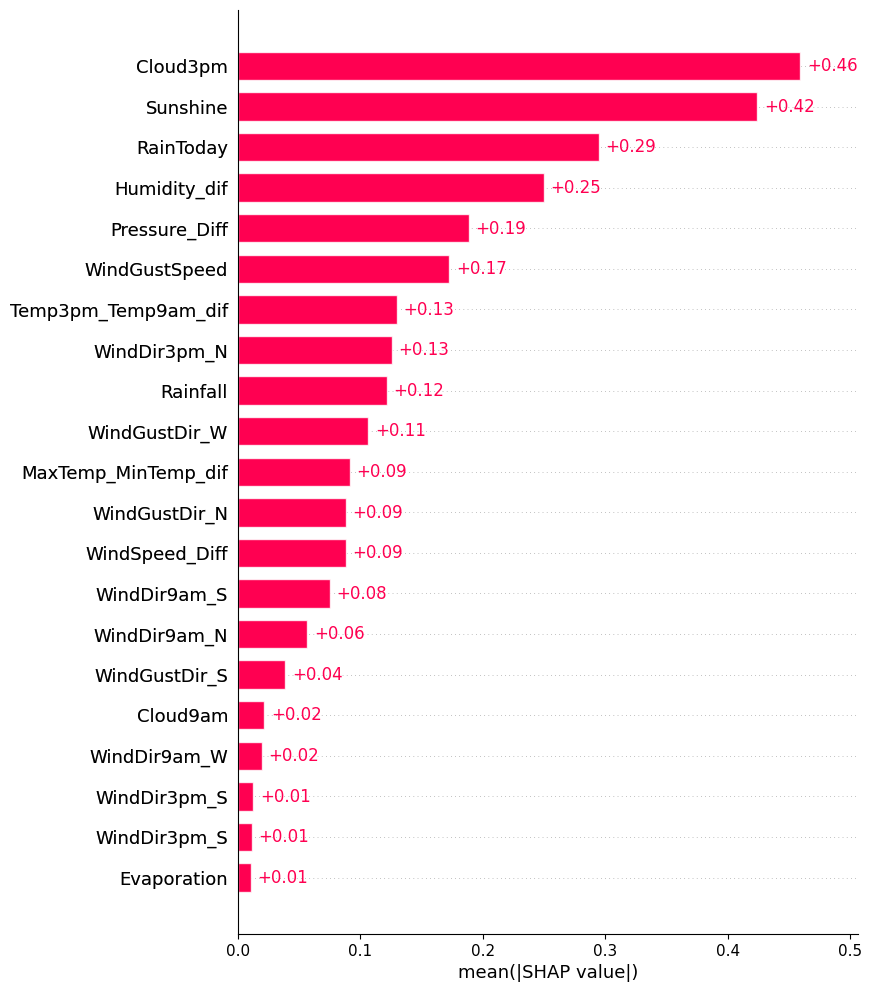

In [158]:
shap.plots.bar(explanation, max_display=21)


A nivel global vemos que las variables mas importantes son Cloud3pm y sunshine

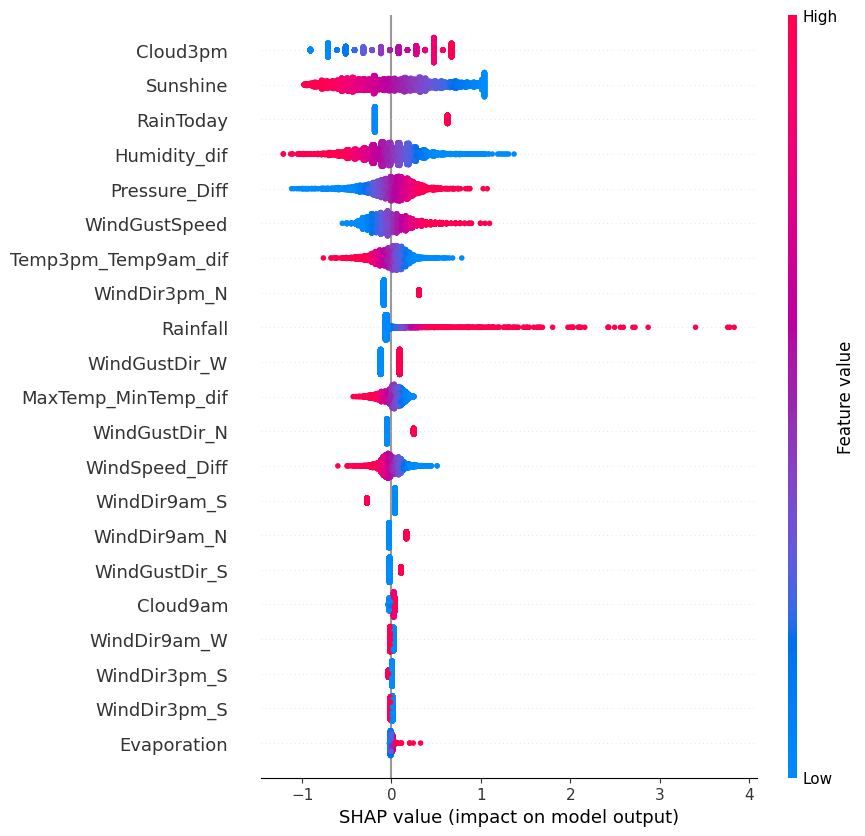

In [159]:
shap.plots.beeswarm(explanation, max_display=21)

Observando el gráfico de abejas podemos decir que cuanto mas nubes hay a las 3pm mas impacto positivo tiene sobre si va a llover mañana.

Con la presión pasa algo similar, cuando hay mayor diferencia de presión entre las 9am y 3pm mas impacto positivo tiene sobre si va a llover mañana.

Cuando llueve una cantidad considerable en el registro que estamos mirando, impacta positivamente sobre si llueve mañana.

#### Explicabilidad Local Regresión

In [160]:
# Crea un objeto explainer SHAP
feature_names=x_train.columns.values
feature_names
explainer = shap.LinearExplainer(lr, x_train, feature_names=feature_names)

In [161]:
shap_values = explainer.shap_values(x_test)
shap_values.shape

(4328, 21)

In [162]:
explainer.expected_value

-1.649731887922653

In [163]:
index=0
lr.predict(x_test)[index]

0

In [164]:
shap_values[index]

array([-0.05393178,  0.05361425,  0.48628667, -0.03890152,  0.00740348,
       -0.68633497, -0.04454832, -0.01690887,  0.07133488, -0.01762041,
        0.04017992,  0.0444533 , -0.09667943, -0.05496046,  0.00191778,
       -0.2054784 ,  0.16146913, -0.11483597, -0.01611704, -0.07359045,
        0.15759148])

In [165]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

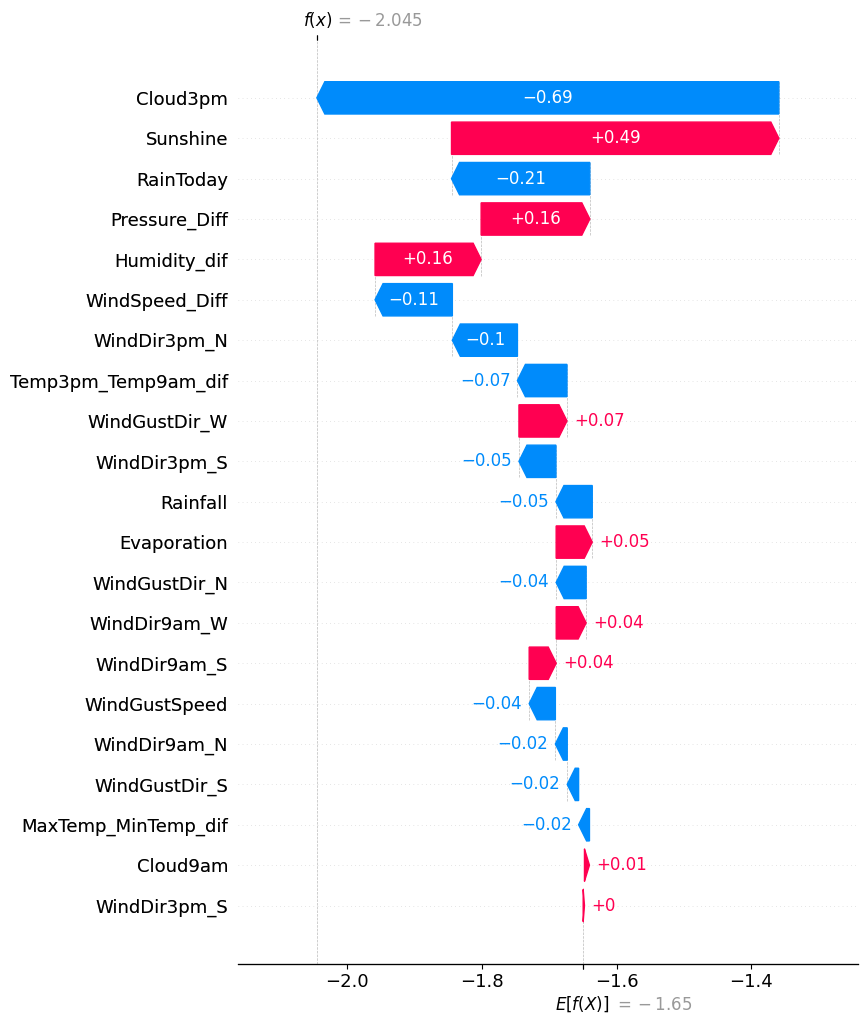

In [166]:
shap.plots.waterfall(explanation, max_display=21)

Las variables que tienen mayor impacto en la cantidad de lluvia de mañana son Sunshine y Cloud3pm

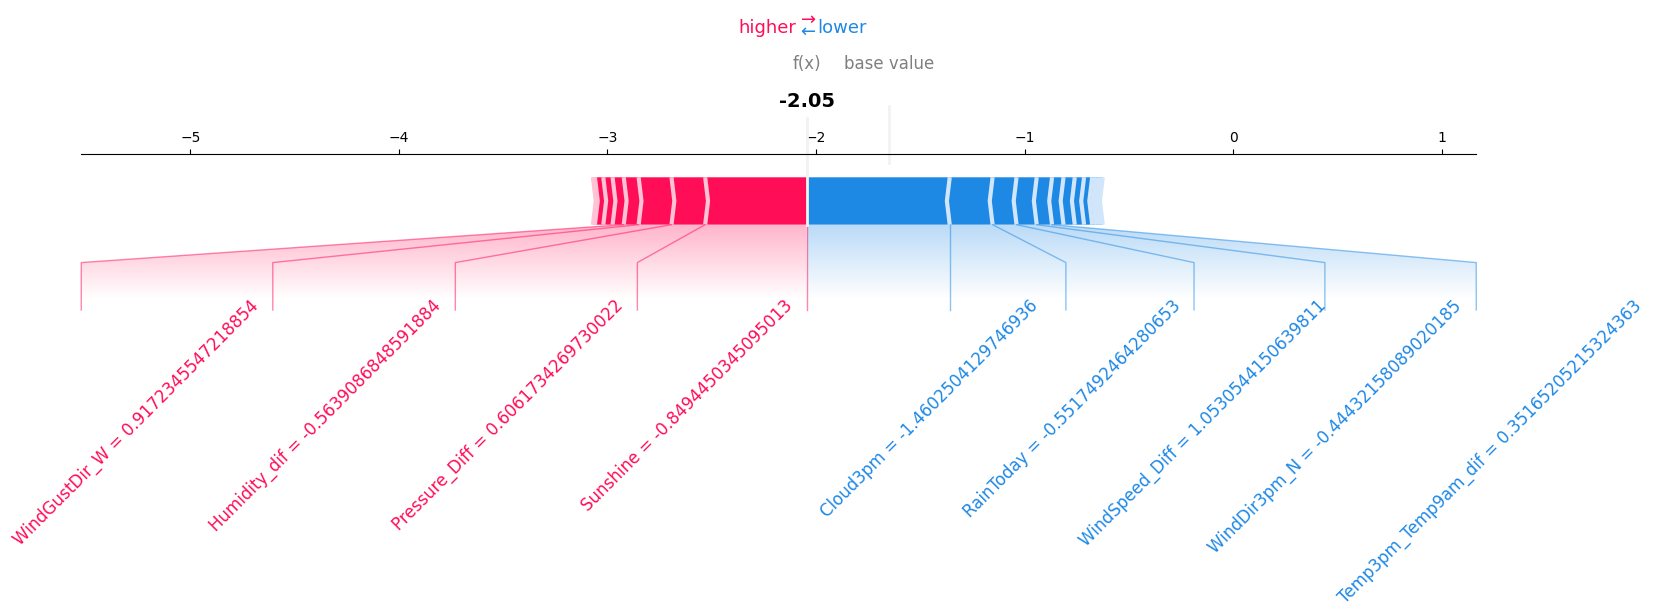

In [167]:
shap.force_plot(explainer.expected_value, shap_values[index], x_test.loc[index], feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=45)

como sunshine es negativa indica que ese día hubo menos sol que el promedio. Lo que lleva a implicar positivamente sobre mi valor base, es decir que mañana llueva.
Cloud también es negativa, entonces a medida que hay menos nubes influye negativamente en que llueva mañana, es decir, que si hay menos nubes hoy, mañana hay menos cantidad de lluvia.

##### Explicabilidad Global Regresión

In [168]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=x_test)

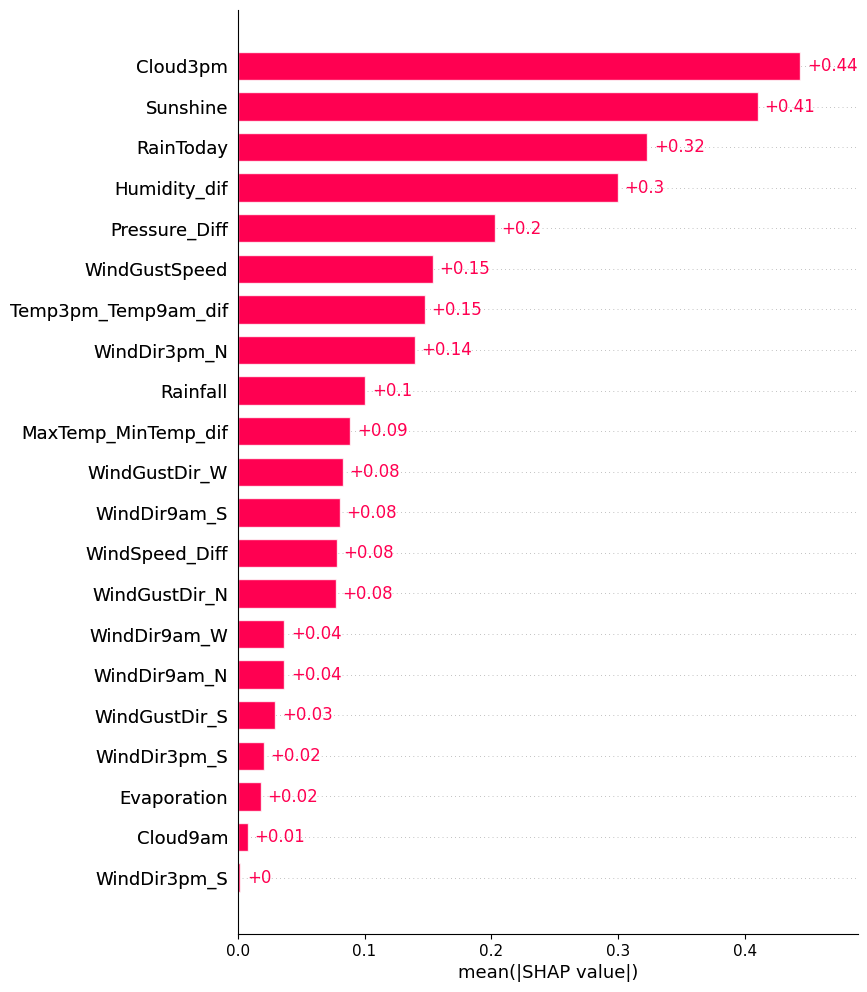

In [169]:
shap.plots.bar(explanation, max_display=21)

A nivel global vemos que las variables mas importantes son sunshine, Humidity_dif , Pressure_Diff y Rainfall

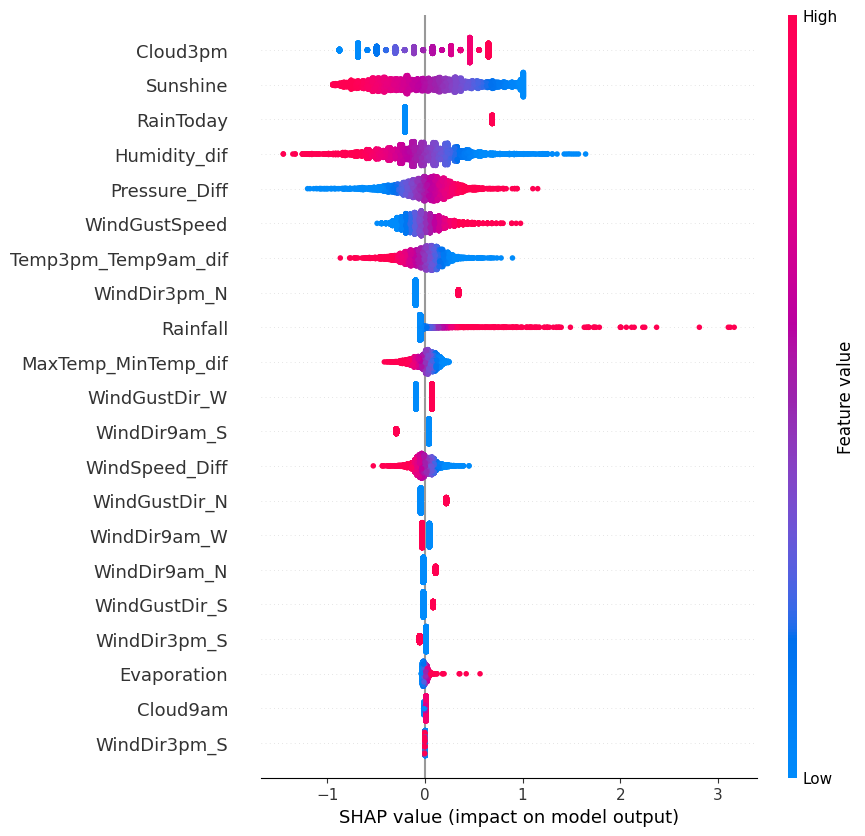

In [170]:
shap.plots.beeswarm(explanation, max_display=21)

Observando el gráfico de abejas podemos decir que cuando hay menos horas de sol en el día mas impacto positivo tiene la variable sunshine sobre la cantidad de lluvia que va a caer mañana.

Con la humedad pasa algo similar, a medida que la diferencia de humedad entre las 9am y 3pm es mas pequeña mas impacto positivo tiene sobre la cantidad de lluvia.

Cuando llueve una cantidad considerable, mi variable Rainfall impacta positivamente sobre la cantidad de lluvia.

Tanto para regresión como para clasificación las primeras 6 variables son las mismas, solo que en distinto orden de impacto

## Redes Neuronales

### Clasificación

In [171]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Redondear las predicciones a 0 o 1
    tp = K.sum(K.cast(y_true * y_pred, 'float'))
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'))
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1



Probamos con 128 neuronas ocultas, 20 epocas y dio el accuracy: 0.7981 - val_accuracy: 0.7881

Probamos con 64 neuronas ocultas, 20 epocas y dio: accuracy: 0.8372 - val_accuracy: 0.8228 

Probamos con 64 neuronas ocultas, 50 epocas y dio: accuracy: 0.8500 - val_accuracy: 0.8172 (si bien dio un accuracy alto en el train, hay mucha diferencia entre validación y train, o sea que hay overfitting)

Probamos con 32 neuronas ocultas, 20 epocas y dio: accuracy: 0.8338 - val_accuracy: 0.8253

Probamos con 32 neuronas ocultas, 40 epocas y dio: accuracy: 0.8426 - val_accuracy: 0.8246

Probamos con 8 neuronas ocultas, 20 epocas y dio: accuracy: 0.8271 - val_accuracy: 0.8159

Probamos con 8 neuronas ocultas, 30 epocas y dio: accuracy: 0.8255 - val_accuracy: 0.8202

### optimización de hiperparámetros

In [172]:
def objective(trial):

    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128) # la cantidad de neuronas de cada capa tambien se puede pasar como hiperparámetro
        # activations = trial.suggest_categorical(f'')
        model.add(Dense(num_units, activation='relu')) # capas densas con activacion ReLU

    # capa de salida
    model.add(Dense(1, activation='sigmoid')) #  es la clase de salida

    # compilar
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Sugerir el número de epochs como hiperparámetro
    epochs = trial.suggest_int('epochs', 5, 50)

    # entrenar
    model.fit(x_train2, y_train2, validation_data=(x_test2, y_test2), epochs=epochs, batch_size=32, verbose=0)

    # evaluar
    score = model.evaluate(x_test2, y_test2, verbose=0)
    return score[1]

# crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# obtener los mejores hiperparámetros
best_params = study.best_params
print("Best parámetros encontrados:", best_params)

[I 2024-06-05 11:10:22,618] A new study created in memory with name: no-name-5291a774-01f7-40f4-b535-3d6ab47a9633
[I 2024-06-05 11:10:48,751] Trial 0 finished with value: 0.7828096151351929 and parameters: {'num_layers': 3, 'n_units_layer_0': 94, 'n_units_layer_1': 98, 'n_units_layer_2': 96, 'epochs': 38}. Best is trial 0 with value: 0.7828096151351929.
[I 2024-06-05 11:11:08,733] Trial 1 finished with value: 0.8188539743423462 and parameters: {'num_layers': 2, 'n_units_layer_0': 23, 'n_units_layer_1': 95, 'epochs': 34}. Best is trial 1 with value: 0.8188539743423462.
[I 2024-06-05 11:11:28,866] Trial 2 finished with value: 0.8022181391716003 and parameters: {'num_layers': 2, 'n_units_layer_0': 54, 'n_units_layer_1': 127, 'epochs': 34}. Best is trial 1 with value: 0.8188539743423462.
[I 2024-06-05 11:11:45,218] Trial 3 finished with value: 0.8174676299095154 and parameters: {'num_layers': 1, 'n_units_layer_0': 54, 'epochs': 30}. Best is trial 1 with value: 0.8188539743423462.
[I 2024-0

Best parámetros encontrados: {'num_layers': 1, 'n_units_layer_0': 125, 'epochs': 21}


In [178]:
# modelo de red neuronal
model = Sequential()
model.add(Dense(125, activation='relu'))  # Capa oculta con 38 neuronas y función de activación ReLU
model.add(Dense(1, activation='sigmoid'))  # Capa de salida con 1 neurona  y función de activación sigmoid

In [179]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [180]:
model.fit(x_train2, y_train2, epochs=21, batch_size=32, validation_data=(x_test2, y_test2))

Epoch 1/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7763 - loss: 0.4557 - val_accuracy: 0.8184 - val_loss: 0.4173
Epoch 2/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.8273 - loss: 0.3904 - val_accuracy: 0.8232 - val_loss: 0.4130
Epoch 3/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8285 - loss: 0.3841 - val_accuracy: 0.8195 - val_loss: 0.4132
Epoch 4/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8340 - loss: 0.3793 - val_accuracy: 0.8212 - val_loss: 0.4124
Epoch 5/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.8272 - loss: 0.3855 - val_accuracy: 0.8214 - val_loss: 0.4129
Epoch 6/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.8326 - loss: 0.3817 - val_accuracy: 0.8223 - val_loss: 0.4142
Epoch 7/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.8319 - loss: 0.3779 - val_accuracy: 0.8202 - val_loss: 0.4160
Epoch 8/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.8294 - loss: 0.3849 - val_ac

explicabilidad local

In [185]:
# Crea un objeto explainer SHAP
x_train2_np = x_train2.values
y_train2_np = y_train2.values 
x_test2_np = x_test2.values
y_test2_np = y_test2.values 
explainer = shap.KernelExplainer(model, x_train2_np)
#mmm no entiendo pq tira esto la verdad

Using 20713 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [184]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(x_test2_np)

  0%|          | 0/4328 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/4328 [00:20<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
explainer.expected_value

-1.649731887922653

In [ ]:
index=0
lr.predict_proba(x_test2)[index]
lr.predict(x_test2)[index]

0

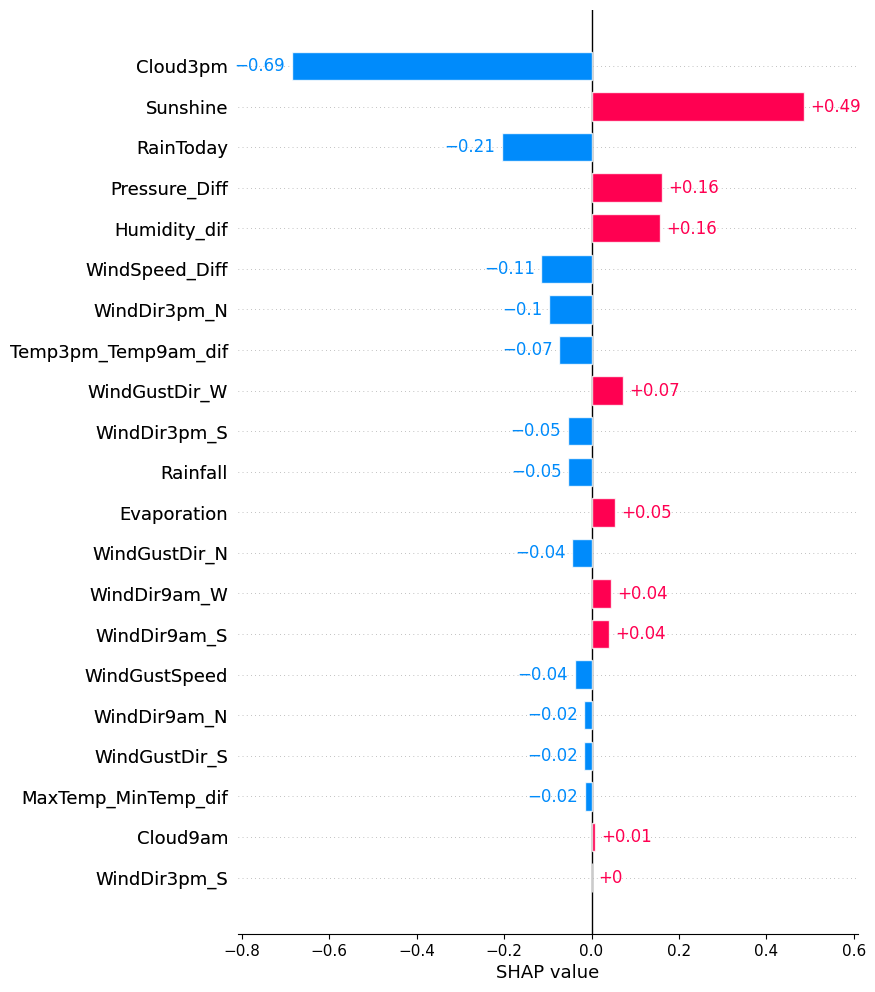

In [ ]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.bar(explanation, max_display=21)

las variables que mas impactan en que llueva mañana a nivel local son cloud3pm y sunshine 

Explicabilidad global

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=x_test2)

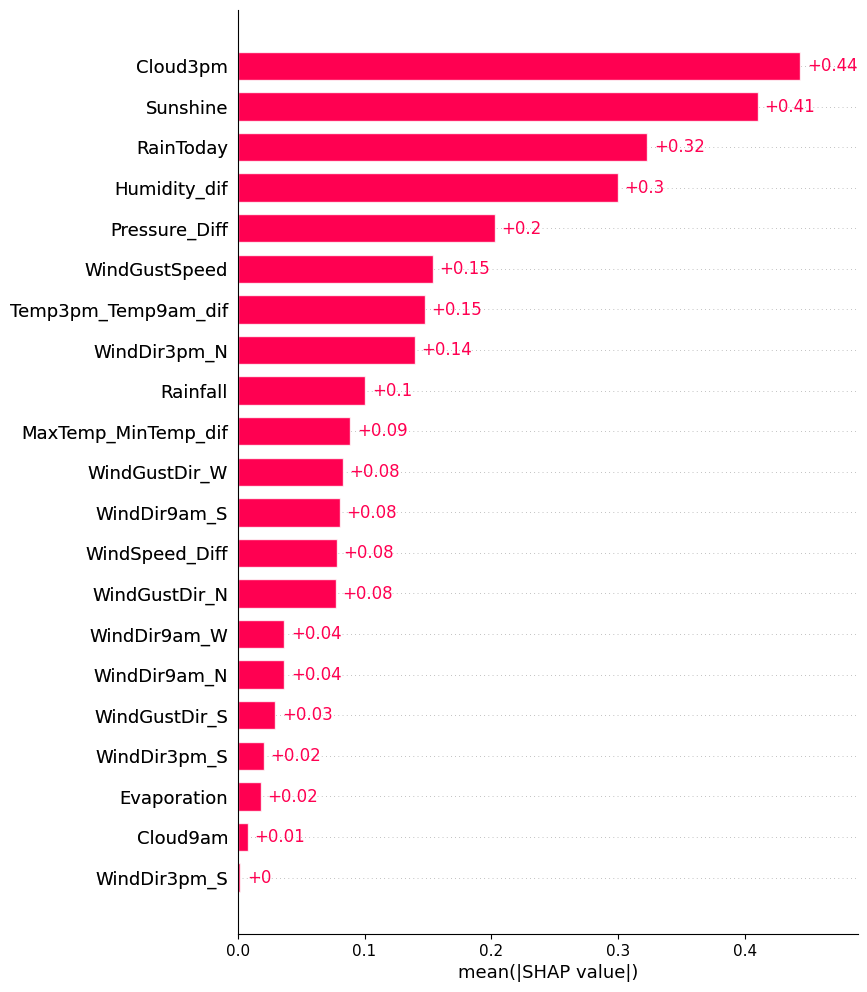

In [ ]:
shap.plots.bar(explanation, max_display=21)

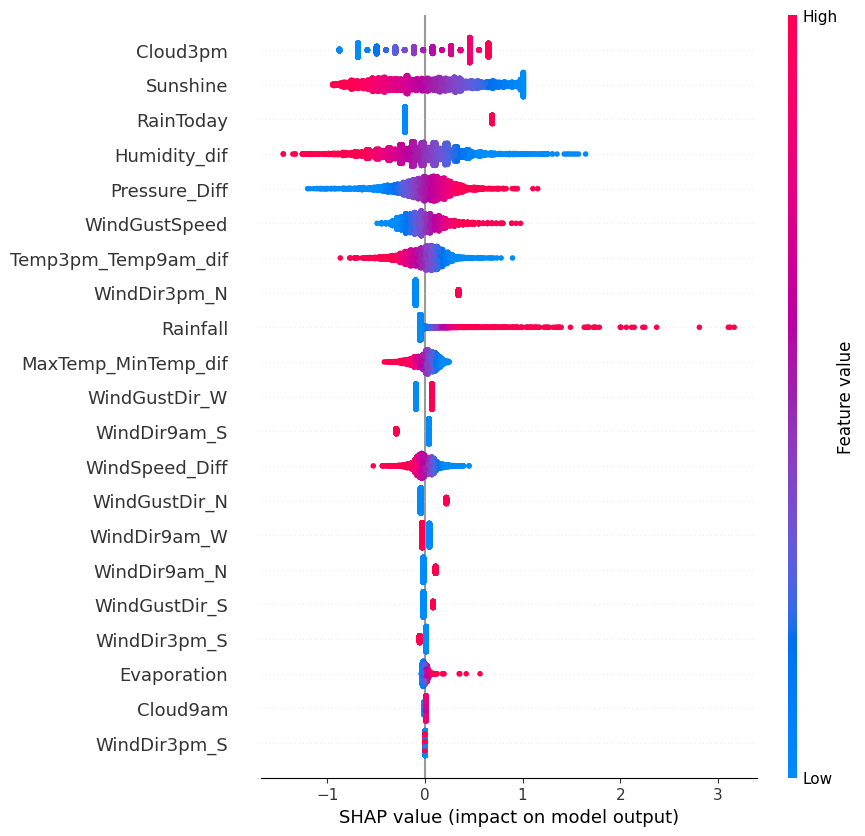

In [ ]:
shap.plots.beeswarm(explanation, max_display=21)

Observando el gráfico de abejas podemos decir que cuanto mas nubes hay a las 3pm mas impacto positivo tiene sobre si va a llover mañana.

Con la presión pasa algo similar, cuando hay mayor diferencia de presión entre las 9am y 3pm mas impacto positivo tiene sobre si va a llover mañana.

### Regresion

In [195]:
class NeuralNetworkTensorFlow:
    """
        Este es un modelo simple con TensorFlow para resolver el mismo problema. 
        En esta clase, (1) se construye el modelo.
        (2) Se define como se fitea el modelo
        (3) Y como se hacen las predicciones.
    """
    def __init__(self, a, b):
        self.valor1= a
        self.valor2= b
        self.model = self.build_model()

    def build_model(self):
        """
            Construye el modelo
            Para construir el modelo es necesario una arquitectura, un optimizador y una función de pérdida.
            La arquitectura se construye con el método Sequential, que basicamente lo que hace es colocar 
            secuencialmente las capas que uno desea.
            Las capas "Dense" son las fully connected dadas en clase.
            Se agrega una capa oculta que recibe un input de tamaño 2,
            y una capa de salida de regresión (una única neurona)
            En todos los casos se define una sigmoidea como función de activación (prueben otras!)

            El optimizador y la función de pérdida se especifican dentro de un compilador.

            Con este método, lo que se devuelve es el modelo sin entrenar, sería equivalente a escribir LinearRegression() 
            en el caso de la regresión lineal.
        """
    
        #input_shape=(self.valor1,self.valor2)
        model = tf.keras.Sequential()
        model.add(Input(shape=(21,)))
        model.add(Dense(2, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='mean_squared_error')
        ### imprimimos la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model
    
    def fit(self, X, y, lr=0.1, epochs=200):
        ### esta es la función donde se entrena el modelo, fijarse que hay un learning rate e iteraciones.
        ### la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución.
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=epochs, verbose=0)
        return history.history['loss']

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

In [190]:
x_train.shape

(20713, 21)

In [197]:
valor1 = 20713
valor2 = 21
nn_tensorflow = NeuralNetworkTensorFlow(valor1, valor2)
loss_history = nn_tensorflow.fit(x_train, y_train, lr=1, epochs=100)

n° de parámetros: 47


In [199]:
predictions = nn_tensorflow.predict(x_train)
print("Predicciones:", predictions)

648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step
Predicciones: [[1.3865985e-03]
 [6.6515080e-05]
 [5.9823258e-05]
 ...
 [5.9522918e-05]
 [6.4128464e-05]
 [1.4271903e-03]]


In [200]:
x1_values = np.linspace(0, 1, 100) 
x2_values = np.linspace(0, 1, 100)
grid_points = np.array([(x1, x2) for x1 in x1_values for x2 in x2_values])

predictions = nn_tensorflow.predict(grid_points)

plt.figure(figsize=(8, 6))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=predictions, cmap='coolwarm')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Mapa de predicciones')
plt.colorbar()
plt.show()

InvalidArgumentError: Graph execution error:

Detected at node sequential_55_1/dense_147_1/Sigmoid defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 639, in run_forever

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1985, in _run_once

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\u631832\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\u631832\AppData\Local\Temp\ipykernel_2124\2726121452.py", line 5, in <module>

  File "C:\Users\u631832\AppData\Local\Temp\ipykernel_2124\128263231.py", line 50, in predict

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 504, in predict

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 204, in one_step_on_data_distributed

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 194, in one_step_on_data

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 92, in predict_step

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 202, in call

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 592, in call

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py", line 154, in call

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\activations\activations.py", line 334, in sigmoid

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 109, in sigmoid

  File "c:\Users\u631832\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 24, in sigmoid

Matrix size-incompatible: In[0]: [32,2], In[1]: [21,2]
	 [[{{node sequential_55_1/dense_147_1/Sigmoid}}]] [Op:__inference_one_step_on_data_distributed_1824808]